In [78]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from sklearn import tree
#from sklearn import LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy import stats
from scipy.stats import truncnorm
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchinfo

import warnings
import os
from copy import deepcopy

import plotting
import dataset_fctns
import modelling_fctns

<Axes: ylabel='Count'>

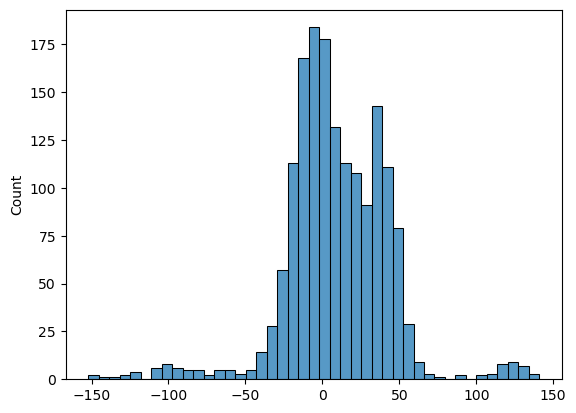

In [23]:
sns.histplot(ds_inputs_DE[[f'NDVI interpolated at day {n}' for n in range(0, 280, 8)]].idxmax(axis=1).apply(lambda word: int(word[25:])) - (ds_inputs_DE['observed time to beginning of flowering'].astype(np.int64) + 56))

In [19]:
ds_inputs_DE[['WC SOS date', 'Day of start']]

,WC SOS date,Day of start
19,2018-04-15,2018-02-18
20,2019-04-15,2019-02-18
21,2020-04-14,2020-02-18
22,2021-04-15,2021-02-18
23,2022-04-15,2022-02-18
...,...,...
21417,2021-04-15,2021-02-18
21418,2022-04-15,2022-02-18
21436,2017-04-17,2017-02-18
21503,2018-04-18,2018-02-18


In [64]:
ds_LSP_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_savgol_raw_4window_MODIS_DE_averaged.csv')
with warnings.catch_warnings(action="ignore"):
    ds_LSP_DE = interpolate_columns(ds_LSP_DE, 270, 'NDVI', resolution=8)
wheat_ripeness_obs = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\wheat_just_ripeness_obs.csv')
wheat_ripeness_obs = wheat_ripeness_obs.rename(columns={'Referenzjahr': 'year', 'Stations_id': 'Stations_Id'})
wheat_ripeness_obs['observed time to yellow ripeness'] = pd.to_timedelta(wheat_ripeness_obs['observed time to yellow ripeness']).dt.days
ds_LSP_DE['year'] = ds_LSP_DE['year'].astype(int)
just_NDVI = ds_LSP_DE.merge(wheat_ripeness_obs, on = ['Stations_Id', 'year'])
just_NDVI = just_NDVI.loc[just_NDVI['observed time to yellow ripeness'] > 0]
just_NDVI = just_NDVI.loc[just_NDVI['NDVI interpolated at day 0'] > 0]

In [38]:
ds_LSP_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_savgol_raw_4window_MODIS_DE_averaged.csv')
with warnings.catch_warnings(action="ignore"):
    ds_LSP_DE = interpolate_columns(ds_LSP_DE, 270, 'NDVI', resolution=8)
wheat_ripeness_obs = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\wheat_just_harvest_obs.csv')
wheat_ripeness_obs = wheat_ripeness_obs.rename(columns={'Referenzjahr': 'year', 'Stations_id': 'Stations_Id'})
wheat_ripeness_obs['observed time to harvest'] = pd.to_timedelta(wheat_ripeness_obs['observed time to harvest']).dt.days
ds_LSP_DE['year'] = ds_LSP_DE['year'].astype(int)
just_NDVI = ds_LSP_DE.merge(wheat_ripeness_obs, on = ['Stations_Id', 'year'])
just_NDVI = just_NDVI.loc[just_NDVI['observed time to harvest'] > 0]
just_NDVI = just_NDVI.loc[just_NDVI['NDVI interpolated at day 0'] > 0]

In [29]:
just_NDVI

,Unnamed: 0_x,year,Stations_Id,Day of start,NDVI interpolated at day 0,NDVI interpolated at day 4,NDVI interpolated at day 8,NDVI interpolated at day 12,NDVI interpolated at day 16,NDVI interpolated at day 20,...,NDVI interpolated at day 260,NDVI interpolated at day 264,NDVI interpolated at day 268,NDVI interpolated at day 272,NDVI interpolated at day 276,Unnamed: 0_y,lat,lon,WC SOS date,observed time to harvest
0,40,2022,7923.0,2022-02-14,0.087834,0.297088,0.454479,0.560007,0.602930,0.591848,...,0.597897,0.660826,0.690068,0.707066,0.711821,6517,52.4000,9.4500,2022-04-14,99
1,41,2022,7920.0,2022-02-14,0.460353,0.517571,0.562218,0.594293,0.614447,0.620723,...,0.712941,0.730772,0.730628,0.716283,0.687739,6385,52.5333,9.4667,2022-04-14,97
2,42,2022,7910.0,2022-02-14,0.362612,0.438989,0.497356,0.537713,0.548365,0.555186,...,0.645069,0.684966,0.688170,0.669906,0.630175,6277,52.3000,9.5000,2022-04-14,106
3,43,2022,7865.0,2022-02-14,0.499495,0.541995,0.574758,0.597786,0.611199,0.605651,...,0.713034,0.656781,0.633446,0.622886,0.625101,5417,52.5667,8.5667,2022-04-14,100
4,44,2022,7857.0,2022-02-14,0.297389,0.416872,0.509937,0.576583,0.634727,0.621528,...,0.540660,0.700531,0.770951,0.789685,0.756733,5281,52.6000,8.8333,2022-04-14,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13920,444,2002,13999.0,2002-02-22,0.125767,0.210158,0.272250,0.312042,0.335355,0.324535,...,0.215423,0.235981,0.261118,0.302333,0.359628,122404,47.6667,9.1833,2002-04-20,103
13921,455,2002,13930.0,2002-02-14,0.564213,0.548004,0.535703,0.527311,0.523382,0.522050,...,0.430101,0.409535,0.393521,0.384917,0.383723,122166,50.3500,8.1667,2002-04-15,120
13922,464,2001,13999.0,2001-02-22,0.073509,0.129280,0.174942,0.210494,0.255157,0.249736,...,0.456325,0.367973,0.280914,0.168258,0.030004,122403,47.6667,9.1833,2001-04-20,105
13923,472,2001,13949.0,2001-02-14,0.528446,0.430338,0.364451,0.330786,0.317118,0.339335,...,0.536378,0.575698,0.567662,0.538693,0.488791,122286,52.2500,8.0500,2001-04-14,110


In [55]:
ds_LSP_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_savgol_raw_sentinel.csv')
with warnings.catch_warnings(action="ignore"):
    ds_LSP_DE = interpolate_columns(ds_LSP_DE, 270, 'NDVI', resolution=8)
flowering_obs = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\just_flowering_obs.csv')
flowering_obs = flowering_obs.rename(columns={'Referenzjahr': 'year', 'Stations_id': 'Stations_Id'})
flowering_obs['observed time to beginning of flowering'] = pd.to_timedelta(flowering_obs['observed time to beginning of flowering']).dt.days
ds_LSP_DE['year'] = ds_LSP_DE['year'].astype(int)
just_NDVI = ds_LSP_DE.merge(flowering_obs, on = ['Stations_Id', 'year'])
just_NDVI = just_NDVI.loc[just_NDVI['observed time to beginning of flowering'] > 0]
just_NDVI = just_NDVI.loc[just_NDVI['NDVI interpolated at day 0'] > 0]

In [61]:
ds_LSP_DE2 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_savgol_raw_4window_MODIS_DE_averaged.csv')
with warnings.catch_warnings(action="ignore"):
    ds_LSP_DE2 = interpolate_columns(ds_LSP_DE2, 270, 'NDVI', resolution=8)
just_NDVI2 = ds_LSP_DE2.merge(flowering_obs, on = ['Stations_Id', 'year'])
just_NDVI2 = just_NDVI2.loc[just_NDVI2['observed time to beginning of flowering'] > 0]
just_NDVI2 = just_NDVI2.loc[just_NDVI2['NDVI interpolated at day 0'] > 0]

In [62]:
just_NDVI2.shape

(13981, 281)

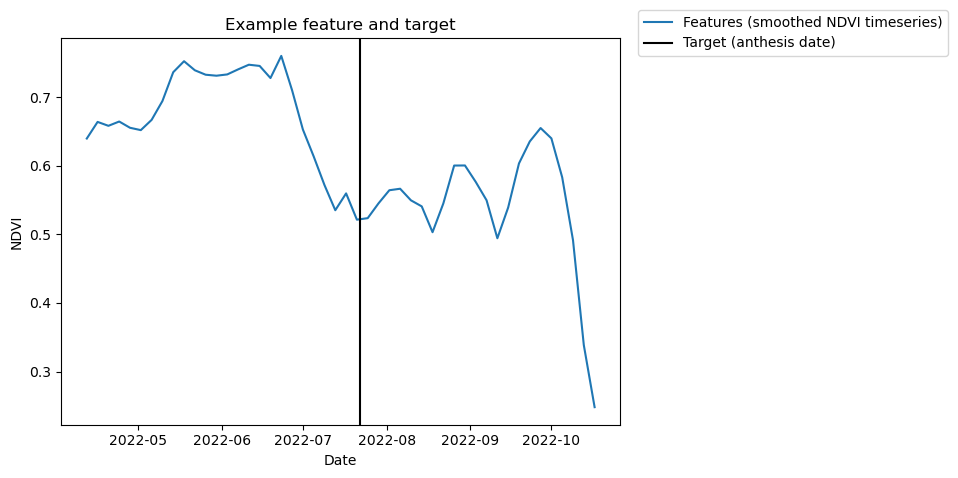

In [47]:
skip = 4
numsteps = int(195 // skip)
NDVI_series_DE = torch.Tensor(just_NDVI[[f'NDVI interpolated at day {56 + skip*n}' for n in range(numsteps)]].values)#12
fig, axs = plt.subplots()
year = just_NDVI2['year'].values[0]
statid = just_NDVI2['Stations_Id'].values[0]
averaged_at_loc = just_NDVI.loc[(just_NDVI['year'] == year)*(just_NDVI['Stations_Id'] == statid)]

specific_at_loc = just_NDVI2.loc[(just_NDVI2['year'] == year)*(just_NDVI2['Stations_Id'] == statid)]
specific_at_loc[[f'NDVI interpolated at day {8 + 2*skip*n}' for n in range(int(numsteps/2))]]

specific_dates = np.datetime64(f'{year}-04-12') + pd.to_timedelta(range(0, numsteps*4, 8), 'D')
average_dates = np.datetime64(f'{year}-04-12') + pd.to_timedelta(range(0, numsteps*4, 4), 'D')

anthesis = np.datetime64(f'{year}-04-12') + pd.to_timedelta(specific_at_loc['observed time to beginning of flowering'].values, 'D')
#anthesis = specific_at_loc['observed time to beginning of flowering'].values
#print(specific_at_loc['observed time to beginning of flowering'])#, specific_at_loc['observed time to beginning of flowering'])
axs.plot(average_dates, averaged_at_loc[[f'NDVI interpolated at day {56 + skip*n}' for n in range(numsteps)]].values.squeeze(), label = 'Features (smoothed NDVI timeseries)')
#axs.plot(range(0, numsteps*4, 8), specific_at_loc[[f'NDVI interpolated at day {8 + 2*skip*n}' for n in range(int(numsteps/2))]].values.squeeze(), label = 'Features (smoothed NDVI timeseries)')
axs.axvline(anthesis, color='black', label = 'Target (anthesis date)')
axs.set_xlabel('Date')
axs.set_ylabel('NDVI')
axs.set_title('Example feature and target')
fig.legend(bbox_to_anchor = (1.5, 1))
fig.tight_layout()
#axs[1].axvline(anthesis)

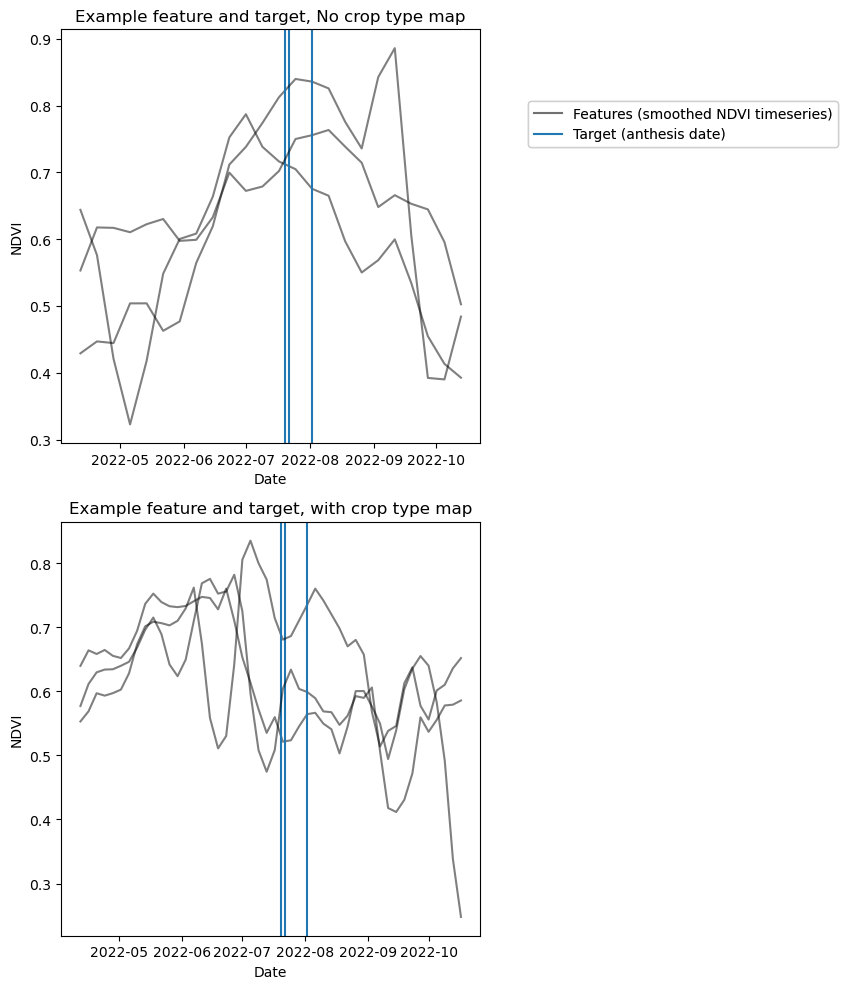

In [56]:
skip = 4
numsteps = int(195 // skip)
NDVI_series_DE = torch.Tensor(just_NDVI[[f'NDVI interpolated at day {56 + skip*n}' for n in range(numsteps)]].values)#12
fig, axs = plt.subplots(2, 1, figsize = (5, 10))
for stat_index in [0, 1, 3]:
    year = just_NDVI2['year'].values[stat_index]
    statid = just_NDVI2['Stations_Id'].values[stat_index]
    averaged_at_loc = just_NDVI.loc[(just_NDVI['year'] == year)*(just_NDVI['Stations_Id'] == statid)]

    specific_at_loc = just_NDVI2.loc[(just_NDVI2['year'] == year)*(just_NDVI2['Stations_Id'] == statid)]
    specific_at_loc[[f'NDVI interpolated at day {8 + 2*skip*n}' for n in range(int(numsteps/2))]]

    anthesis = np.datetime64(f'{year}-04-12') + pd.to_timedelta(specific_at_loc['observed time to beginning of flowering'].values, 'D')
    #print(specific_at_loc['observed time to beginning of flowering'])#, specific_at_loc['observed time to beginning of flowering'])
    specific_dates = np.datetime64(f'{year}-04-12') + pd.to_timedelta(range(0, numsteps*4, 8), 'D')
    if stat_index == 0:
        axs[0].plot(specific_dates, specific_at_loc[[f'NDVI interpolated at day {8 + 2*skip*n}' for n in range(int(numsteps/2))]].values.squeeze(),  
                    label = 'Features (smoothed NDVI timeseries)', color = 'black', alpha = 0.5)
        axs[0].axvline(anthesis, label = 'Target (anthesis date)')
        axs[1].plot(average_dates, averaged_at_loc[[f'NDVI interpolated at day {56 + skip*n}' for n in range(numsteps)]].values.squeeze(), color = 'black', alpha = 0.5)
        axs[1].axvline(anthesis)
    else:
        axs[0].plot(specific_dates, specific_at_loc[[f'NDVI interpolated at day {8 + 2*skip*n}' for n in range(int(numsteps/2))]].values.squeeze(), color = 'black', alpha = 0.5)
        axs[0].axvline(anthesis)
        average_dates = np.datetime64(f'{year}-04-12') + pd.to_timedelta(range(0, numsteps*4, 4), 'D')
        axs[1].plot(average_dates, averaged_at_loc[[f'NDVI interpolated at day {56 + skip*n}' for n in range(numsteps)]].values.squeeze(), color = 'black', alpha = 0.5)
        axs[1].axvline(anthesis)
    for i, ax in enumerate(axs):
        ax.set_xlabel('Date')
        ax.set_ylabel('NDVI')
        crop_type_map = ['No crop type map', 'with crop type map'][i]
        ax.set_title(f'Example feature and target, {crop_type_map}')
    fig.legend(bbox_to_anchor = (1.7, 0.9))
    fig.tight_layout()

In [17]:
just_NDVI2[['Day of start', 'WC SOS date']]

,Day of start,WC SOS date
0,2022-04-03,2022-04-16
1,2022-04-03,2022-04-15
2,2022-04-03,2022-04-14
3,2022-04-03,2022-04-14
4,2022-04-03,2022-04-14
...,...,...
2462,2017-04-03,2017-04-15
2463,2017-04-03,2017-04-14
2464,2017-04-03,2017-04-21
2465,2017-04-03,2017-04-13


In [79]:
def get_station_locations_SSA(dataset, ds_stations):
    ds_stations.index = ds_stations['LocationID']#sitecode
    lat = [ds_stations._get_value(row, col) for row, col in zip(dataset['Stations_Id'], ['Latitude' for count in range(len(dataset))])] #station_data.lookup(row_labels = dataset['Stations_id'], col_labels = ['geograph.Breite'])
    lon = [ds_stations._get_value(row, col) for row, col in zip(dataset['Stations_Id'], ['Longitude' for count in range(len(dataset))])] #station_data._lookup(dataset['Stations_id'], ['geograph.Laenge'])
    dataset['lat'] = lat
    dataset['lon'] = lon
    dataset['lat'] = dataset['lat'].map(lambda x: x[0] if isinstance(x, float) == False else x)
    dataset['lon'] = dataset['lon'].map(lambda x: x[0] if isinstance(x, float) == False else x)
    return dataset

def subsample(ds, subsample_frac = 0.5):
    np.random.seed(0)
    subsample = np.random.choice(ds.shape[0],np.int64(np.floor(ds.shape[0]*subsample_frac)), replace = False)
    #print(np.arange(ds.shape[0]),np.int64(np.floor(ds.shape[0]*subsample_frac)))
    ds_training = ds.loc[subsample, :]
    complement_of_subsample = np.delete(np.arange(ds.shape[0]), subsample)
    #print(len(complement_of_subsample), ds.shape[0], len(subsample))
    ds_verification = ds.loc[complement_of_subsample, :]
    return ds_training, ds_verification

def make_cumulative(ds, driver_variable = 'tas', numdays = 200, T_base = 0):
    ds.loc[:, [f'{driver_variable} at day {n}' for n in range(numdays)]] = (np.maximum(ds.loc[:, [f'{driver_variable} at day {n}' for n in range(numdays)]] - T_base, 0)).cumsum(axis = 1)
    return ds

def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

def r2_modelled_observed(ds, phases):
    for phase in phases:
        print(f'\n{phase}')
        model_perts = ds[f'modelled time to {phase}'].dropna().values# - ds[f'modelled time to {phase}'].dropna().values.mean()
        obs_perts = ds[f'observed time to {phase}'].dropna().values# - ds[f'observed time to {phase}'].dropna().values.mean()
        RF_perts = ds[f'RF to {phase}'].dropna().values #- ds[f'RF to {phase}'].dropna().values.mean()
        r2_score_model = r2_score(obs_perts, model_perts)#.dropna()_score
        r2_score_RF = r2_score(obs_perts, RF_perts)#
        print(f'\nmodelled time emergence to {phase}, R2 score: {r2_score_model}', 
              f'\nML prediction emergence to {phase}, R2 score: {r2_score_RF}')
        
def box_plot_modelled_observed(ds, phases, font_size = 20):
    for phase in phases:
        fig, ax = plt.subplots(figsize = (10, 10))
        r2_score_model = r2_score(ds[f'observed time to {phase}'].dropna().values, ds[f'modelled time to {phase}'].dropna().values)
        r2_score_RF = r2_score(ds[f'observed time to {phase}'].dropna().values, ds[f'RF to {phase}'].dropna().values)
        ax.boxplot([ds[f'modelled time to {phase}'].dropna(), 
                    ds[f'RF to {phase}'].dropna(), 
                    ds[f'observed time to {phase}'].dropna()], 
                   tick_labels=[f'modelled time emergence to\n{phase},\nR2 score: {r2_score_model}', 
                                f'ML prediction emergence to\n{phase},\nR2 score: {r2_score_RF}', 
                                f'observed time emergence to\n{phase}'], 
                   widths = 0.5, showfliers=False) #positions = [obs_this_phase['Stations_id'].unique()[0]],
        #ax.set_ylim(0, 100)
        plt.xticks(rotation = 90)
        ax.tick_params(labelsize = font_size)
        ax.set_title(f'Modelled and observed times to {phase}', fontsize = font_size)
        ax.set_ylabel('Time (days)', fontsize = font_size)
        fig.savefig(f'plots/ML_modelled_observed_{phase}.png', bbox_inches='tight')

def test_hyperparameters(ds_training, ds_verification, driver_variable = 'tas', numdays = 200, max_depth = 10, n_estimators = 100, min_samples_leaf = 1):
    X_train = ds_training[[f'{driver_variable} day {n}' for n in range(numdays)]].values
    y_train = ds_training[[f'observed time to {phase}' for phase in phases]].values
    X_test = ds_verification[[f'{driver_variable} day {n}' for n in range(numdays)]].values
    y_test = ds_verification[[f'observed time to {phase}' for phase in phases]].values
    RF = RandomForestClassifier(max_depth = max_depth, n_estimators = n_estimators, min_samples_leaf = min_samples_leaf)
    RF.fit(X_train, y_train)
    y_pred = RF.predict(X_test)
    r2_score_RF = r2_score(y_test, y_pred)
    print(f'\nmodelled time emergence to {phase}, R2 score: {r2_score_RF}')

def get_station_locations(dataset, ds_stations):
    ds_stations.index = ds_stations['Stations_id']
    lat = [ds_stations._get_value(row, col) for row, col in zip(dataset['Stations_id'], ['geograph.Breite' for count in range(len(dataset))])] #station_data.lookup(row_labels = dataset['Stations_id'], col_labels = ['geograph.Breite'])
    lon = [ds_stations._get_value(row, col) for row, col in zip(dataset['Stations_id'], ['geograph.Laenge' for count in range(len(dataset))])] #station_data._lookup(dataset['Stations_id'], ['geograph.Laenge'])
    dataset['lat'] = lat
    dataset['lon'] = lon
    dataset['lat'] = dataset['lat'].map(lambda x: x[0] if isinstance(x, float) == False else x)
    dataset['lon'] = dataset['lon'].map(lambda x: x[0] if isinstance(x, float) == False else x)
    return dataset

def read_reanalysis():
    ds_t2m = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data2_t2m.csv')
    ds_t2m = ds_t2m.drop('Unnamed: 0', axis = 1)
    ds_d2m = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data2_d2m.csv')
    ds_d2m = ds_d2m.drop('Unnamed: 0', axis = 1)
    ds_ssrd = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data2_ssrd.csv')
    ds_ssrd = ds_ssrd.drop('Unnamed: 0', axis = 1)
    ds_tp = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data2_tp.csv')
    ds_tp = ds_tp.drop('Unnamed: 0', axis = 1)
    t_and_d = pd.merge(ds_t2m[[f't2m at day {day}' for day in range(200)] + ['Stations_id', 'Referenzjahr', 'observed time to beginning of flowering', 'observed time to yellow ripeness', 'observed time to beginning of emergence']],
                    ds_d2m[[f'd2m at day {day}' for day in range(200)] + ['Stations_id', 'Referenzjahr']], on =['Stations_id', 'Referenzjahr'])
    rad_and_prec = pd.merge(ds_ssrd[[f'ssrd at day {day}' for day in range(200)] + ['Stations_id', 'Referenzjahr']],
                            ds_tp[[f'tp at day {day}' for day in range(200)] + ['Stations_id', 'Referenzjahr']], on =['Stations_id', 'Referenzjahr'])
    ds_reanalysis = pd.merge(t_and_d, rad_and_prec, on =['Stations_id', 'Referenzjahr'])
    ds_reanalysis = ds_reanalysis.rename(columns={'Stations_id': 'Stations_Id', 'Referenzjahr': 'year'})
    ds_reanalysis['year'] = ds_reanalysis['year'].astype(int)
    return ds_reanalysis

def loc_and_SOS(ds_inputs, predictor_type = 'savgol'):
    station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')
    ds_inputs = dataset_fctns.get_station_locations(ds_inputs, station_data, check_lists = False)
    ds_inputs = dataset_fctns.add_SOS_to_df(ds_inputs)
    ds_inputs['WC SOS date'] = pd.to_datetime(ds_inputs['year'], format = '%Y') + pd.to_timedelta(ds_inputs['SOS'], unit = 'D')
    if predictor_type == 'savgol' or predictor_type == 'thresholds_dates' or predictor_type == 'percentiles_dates':
        if predictor_type == 'savgol':
            date_columns = ['mingrad', 'maxgrad', 'minday', 'maxday', 'first 50 percentile', 'last 50 percentile', 'first 90 percentile', 'last 90 percentile']#'second last 75 percentile', 'last 75 percentile']
        elif predictor_type == 'thresholds_dates':
            date_columns = [f'first time crossing threshold {percent}%' for percent in range(100)] + [f'last time crossing threshold {percent}%' for percent in range(100)]
        elif predictor_type == 'percentiles_dates':
            date_columns = [f'first time crossing percentile {percent}%' for percent in range(100)] + [f'last time crossing percentile {percent}%' for percent in range(100)]
        elif predictor_type == 'MVI' or predictor_type == 'savgol_raw':
            date_columns = []
        for column in date_columns:
            ds_inputs[column] = pd.to_datetime(ds_inputs[column])
            ds_inputs[column] = ds_inputs[column] - ds_inputs['WC SOS date']
            ds_inputs[column] = ds_inputs[column].dt.days 
    return ds_inputs

def offset_dates(row, offset_sample):
    row_NDVI = row.loc[[f'NDVI interpolated at day {offset_sample[row.name] + n}' for n in range(200)]]
    row_NDVI.index = [f'NDVI interpolated at day {n}' for n in range(200)]
    row_temp = row.loc[[f't2m at day {offset_sample[row.name] + n}' for n in range(200)]]
    row_temp.index = [f't2m at day {n}' for n in range(200)]
    row_phases = row.loc[['observed time to beginning of emergence', 'observed time to beginning of flowering', 'observed time to yellow ripeness']]
    row_phases = row_phases + np.timedelta64(60 - offset_sample[row.name], 'D')
    return pd.concat([row_NDVI, row_temp, row_phases], axis=0)

def interpolate_columns(ds, numdays, varname, resolution = 4):
    for day in range(numdays):
        upper = int((day // resolution)*resolution + resolution)
        lower = int((day // resolution)*resolution)
        coeff = (day % resolution)/resolution
        #print(lower, upper, coeff)
        #print(ds.loc[:, f'{varname} interpolated at day {upper}'].mean(), ds.loc[:, f'{varname} interpolated at day {lower}'].mean())
        ds.loc[:, f'{varname} interpolated at day {day}'] = coeff*ds.loc[:, f'{varname} interpolated at day {upper}'] + (1 - coeff)*ds.loc[:, f'{varname} interpolated at day {lower}']
    return ds

def plot_ts_and_phen(ds, fig, ax, numdays = 274):
    for i in ds.index:
        series_at_index = ds.loc[i, :]
        Times = pd.to_datetime(series_at_index['Day of start']) + pd.to_timedelta(np.arange(0, numdays), 'D')
        Values = series_at_index[[f'NDVI interpolated at day {n}' for n in range(numdays)]]
        observation = pd.to_datetime(series_at_index['WC SOS date']) + pd.to_timedelta(series_at_index['observed time to beginning of flowering'], 'D')
        ax.plot(Times, Values)
        ax.axvline(observation)

def sample_augmented_frame(ds_inputs):
    series_length = 190
    offset_sample = np.int64(truncnorm.rvs(-1, 1, size=len(ds_inputs))*30) + 30
    #SOS_dates = ds_inputs['WC SOS date'] + pd.to_timedelta(offset_sample, 'D')#.shape
    ds_augmented = ds_inputs.loc[:, ['observed time to beginning of emergence',
                            'observed time to beginning of flowering',
                            'observed time to yellow ripeness',
                            'lat',
                            'lon',
                            'year',
                            'Stations_id',
                            'Day of start']]
    ds_augmented.loc[:, [f'NDVI interpolated at day {n}' for n in range(series_length)]] = np.zeros((len(ds_inputs), series_length))#np.array([0 for count in range(len(ds_inputs))])
    ds_augmented.loc[:, [f't2m at day {n}' for n in range(series_length)]] = np.zeros((len(ds_inputs), series_length))
    for row_number, row_index in enumerate(ds_inputs.index):
        print(row_number)
        augmented_start = offset_sample[row_number]
        ds_augmented.loc[row_index, [f'NDVI interpolated at day {n}' for n in range(series_length)]] = ds_inputs.loc[row_index, [f'NDVI interpolated at day {n + augmented_start}' for n in range(series_length)]]
        ds_augmented.loc[row_index, [f't2m at day {n}' for n in range(series_length)]] = ds_inputs.loc[row_index, [f't2m at day {n + augmented_start}' for n in range(series_length)]]
        #for n in range(series_length):
        #    
            #ds_augmented.loc[row_index, f'NDVI interpolated at day {n}'] = ds_inputs.loc[row_index, f'NDVI interpolated at day {n + augmented_start}']
            #ds_augmented.loc[row_index, f't2m at day {n}'] = ds_inputs.loc[row_index, f't2m at day {n + augmented_start}']
        for phase in ['beginning of emergence', 'beginning of flowering', 'yellow ripeness']:
            ds_augmented.loc[row_index, f'observed time to {phase}'] = pd.to_timedelta(ds_inputs.loc[row_index, f'observed time to {phase}']) + np.timedelta64(60 - augmented_start, 'D')
    return ds_augmented

In [80]:
ds_reanalysis_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\Maize_ML_data_Africa_t2m_PD_SOS.csv')
ds_reanalysis_SSA['Referenzjahr'] = pd.to_datetime(ds_reanalysis_SSA['WC SOS date']).dt.year
ds_reanalysis_SSA = ds_reanalysis_SSA.drop('Unnamed: 0', axis = 1).rename(columns={'Stations_id': 'Stations_Id', 'Referenzjahr': 'year'})
ds_reanalysis_SSA['year'] = ds_reanalysis_SSA['year'].astype(int)
ds_LSP_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\LSP_savgol_raw_MODIS_SSA_PD_SOS.csv')
#ds_LSP_SSA = ds_LSP_SSA.drop('Unnamed: 0', axis = 1)
#ds_LSP_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\GDD_time_MODIS_savgol_NDVI_SSA.csv')
ds_LSP_SSA = ds_LSP_SSA.drop(['Unnamed: 0'], axis = 1).rename(columns={'Stations_id': 'Stations_Id'})
ds_inputs_SSA = pd.merge(ds_LSP_SSA, ds_reanalysis_SSA, on=['Stations_Id', 'year'], how='outer').dropna(how='any')
ds_inputs_SSA['WC SOS date'] = pd.to_datetime(ds_inputs_SSA['WC SOS date'])
date_columns = ['mingrad', 'maxgrad', 
                'minday', 'maxday', 
                'first 50 percentile', 'last 50 percentile', 
                'first 90 percentile', 'last 90 percentile', 
                'observed time to beginning of flowering']
ds_inputs_SSA['observed time to beginning of flowering'] = pd.to_timedelta(ds_inputs_SSA['observed time to beginning of flowering']).dt.days
ds_inputs_SSA = ds_inputs_SSA.loc[ds_inputs_SSA['observed time to beginning of flowering'] > 0]
with warnings.catch_warnings(action="ignore"):
    ds_inputs_SSA = interpolate_columns(ds_inputs_SSA, 270, 'NDVI', resolution=8)
ds_inputs_SSA.loc[:, [f'temperature at day {n}' for n in range(300)]] = modelling_fctns.Wang_Engel_Temp_response(ds_inputs_SSA.loc[:, [f'temperature at day {n}' for n in range(300)]], 7, 28, 42)
ds_inputs_SSA = make_cumulative(ds_inputs_SSA, driver_variable = 'temperature', numdays = 300, T_base = 0)
stations_data_lobell = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\Lobell2011\\EIL_site_latlon.csv')
ds_inputs_SSA = get_station_locations_SSA(ds_inputs_SSA, stations_data_lobell)
ds_inputs_SSA = ds_inputs_SSA.rename(columns={'Stations_Id':'Stations_id'})
ds_inputs_SSA = ds_inputs_SSA.loc[(ds_inputs_SSA['NDVI interpolated at day 0'] >= 0)*(ds_inputs_SSA['NDVI interpolated at day 32'] >= 0)]
#ds_inputs_SSA = ds_inputs_SSA.loc[(ds_inputs_SSA['NDVI at GDD 0'] >= 0)*(ds_inputs_SSA['NDVI at GDD 200'] >= 0)]
#ds_inputs_SSA['observed time to beginning of flowering'] = pd.to_timedelta(ds_inputs_SSA['observed time to beginning of flowering']) - (pd.to_datetime(ds_inputs_SSA['Day of start']) - pd.to_datetime(ds_inputs_SSA['WC SOS date']))
#for column in date_columns:
#    ds_inputs_SSA[column] = pd.to_datetime(ds_inputs_SSA[column])
#    ds_inputs_SSA[column] = ds_inputs_SSA[column] - ds_inputs_SSA['WC SOS date']
#    ds_inputs_SSA[column] = ds_inputs_SSA[column].dt.days 
                

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_21736\2104312202.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset['lat'] = lat
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_21736\2104312202.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset['lon'] = lon


In [46]:
ds_inputs_SSA

,year,Stations_id,Day of start,NDVI interpolated at day 0,NDVI interpolated at day 8,NDVI interpolated at day 16,NDVI interpolated at day 24,NDVI interpolated at day 32,NDVI interpolated at day 40,NDVI interpolated at day 48,...,temperature at day 293,temperature at day 294,temperature at day 295,temperature at day 296,temperature at day 297,temperature at day 298,temperature at day 299,observed time to beginning of flowering,lat,lon
1,2003,7.0,2003-12-11,0.566747,0.617153,0.656068,0.683492,0.705096,0.700346,0.700028,...,253.491776,254.354107,255.158217,256.005391,256.867559,257.702703,0.869122,65,-9.42,15.75
2,2005,7.0,2005-01-25,0.678146,0.679442,0.683504,0.690333,0.701481,0.710605,0.722242,...,253.188040,254.022938,254.811281,255.667444,256.532768,257.389783,0.848971,74,-9.42,15.75
3,2003,8.0,2003-12-19,0.380465,0.463510,0.534929,0.594723,0.671058,0.686973,0.681222,...,229.736966,230.615603,231.473955,232.334530,233.184189,234.007824,0.805147,70,-11.42,15.12
4,2005,8.0,2005-02-02,0.561230,0.616172,0.658337,0.687726,0.698083,0.706401,0.702307,...,238.832119,239.648760,240.469526,241.291759,242.106605,242.881334,0.823469,67,-11.42,15.12
5,2000,9.0,2000-12-26,0.731233,0.715557,0.701593,0.689343,0.674626,0.664640,0.663897,...,196.594835,197.463471,198.325106,199.192558,200.063857,200.950198,0.837503,84,-12.73,15.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,2000,1063.0,2000-12-02,0.640870,0.678073,0.694748,0.690895,0.659708,0.614192,0.582298,...,179.071406,179.817710,180.636547,181.532048,182.458039,183.367478,0.899091,71,-17.70,31.20
252,2002,1063.0,2002-12-03,0.634264,0.618611,0.616159,0.626909,0.679380,0.697346,0.700806,...,186.347908,187.114407,187.959222,188.860164,189.777940,190.554757,0.718050,66,-17.70,31.20
253,2002,1064.0,2002-12-03,0.545445,0.580451,0.604054,0.616254,0.636422,0.618360,0.607174,...,186.795787,187.562239,188.405804,189.305879,190.225324,191.004230,0.717023,130,-17.67,31.17
254,2005,1064.0,2005-12-19,0.651660,0.630104,0.620113,0.621686,0.624776,0.671016,0.696604,...,180.130134,181.001761,181.832265,182.671811,183.528447,184.272875,0.717488,68,-17.67,31.17


<Axes: xlabel='NDVI at GDD 200', ylabel='Count'>

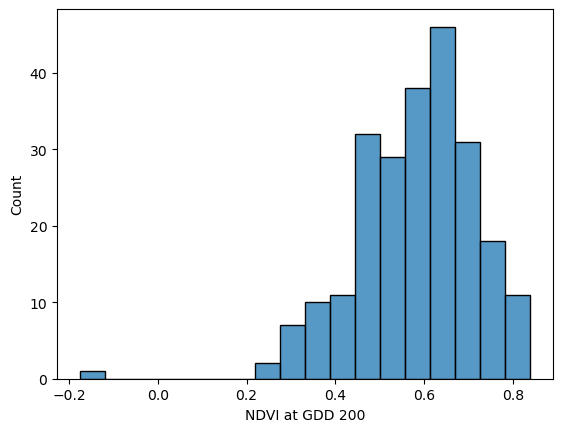

In [60]:
sns.histplot(ds_inputs_SSA['NDVI at GDD 200'])

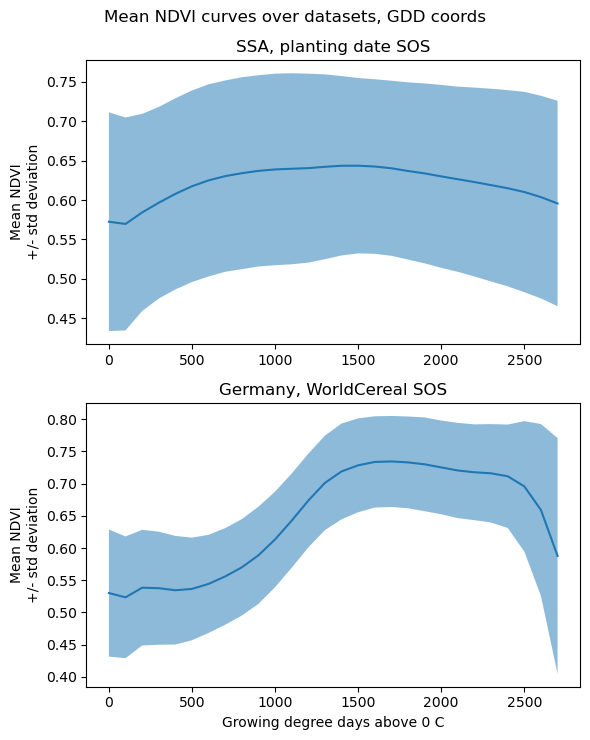

In [68]:
NDVI_SSA = ds_inputs_SSA[[f'NDVI at GDD {n}' for n in range(0, 2800, 100)]].mean(axis=0)
std_SSA = ds_inputs_SSA[[f'NDVI at GDD {n}' for n in range(0, 2800, 100)]].std(axis=0)
fig, axs = plt.subplots(2, 1, figsize = (6, 7.5))
axs[0].plot(range(0, 2800, 100), NDVI_SSA)
axs[0].fill_between(range(0, 2800, 100), NDVI_SSA - std_SSA, NDVI_SSA + std_SSA, alpha=0.5)
axs[0].set_title('SSA, planting date SOS')
axs[0].set_ylabel('Mean NDVI\n+/- std deviation')

NDVI_DE = ds_inputs_DE[[f'NDVI at GDD {n}' for n in range(0, 2800, 100)]].mean(axis=0)
std_DE = ds_inputs_DE[[f'NDVI at GDD {n}' for n in range(0, 2800, 100)]].std(axis=0)
axs[1].plot(range(0, 2800, 100), NDVI_DE)
axs[1].fill_between(range(0, 2800, 100), NDVI_DE - std_DE, NDVI_DE + std_DE, alpha=0.5)
axs[1].set_title('Germany, WorldCereal SOS')
axs[1].set_ylabel('Mean NDVI\n+/- std deviation')
axs[1].set_xlabel('Growing degree days above 0 C')

fig.suptitle('Mean NDVI curves over datasets, GDD coords')
fig.tight_layout()

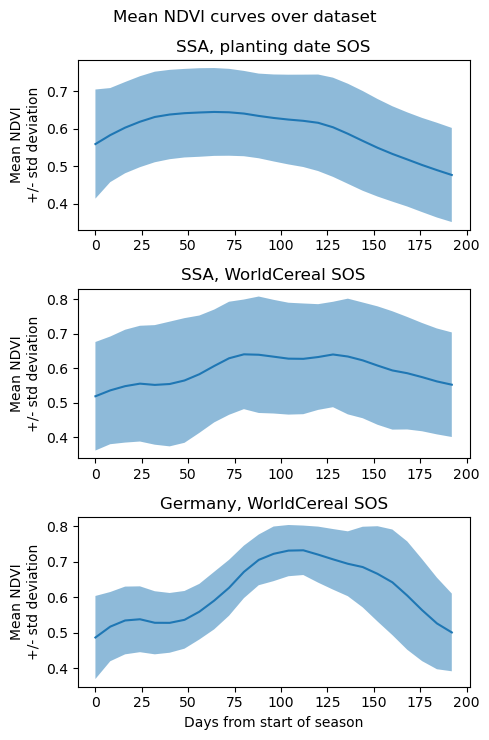

In [71]:
ds_LSP_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\LSP_savgol_raw_MODIS_SSA_PD_SOS.csv')
ds_LSP_SSA = ds_LSP_SSA.drop('Unnamed: 0', axis = 1)
ds_inputs_SSA = pd.merge(ds_LSP_SSA, ds_reanalysis_SSA, on=['Stations_Id', 'year'], how='outer').dropna(how='any')
ds_inputs_SSA['observed time to beginning of flowering'] = pd.to_timedelta(ds_inputs_SSA['observed time to beginning of flowering']).dt.days
ds_inputs_SSA = ds_inputs_SSA.loc[ds_inputs_SSA['observed time to beginning of flowering'] > 0]
ds_inputs_SSA = ds_inputs_SSA.loc[(ds_inputs_SSA['NDVI interpolated at day 0'] >= 0)*(ds_inputs_SSA['NDVI interpolated at day 32'] >= 0)]
NDVI_SSA = ds_inputs_SSA[[f'NDVI interpolated at day {n}' for n in range(0, 194, 8)]].mean(axis=0)
std_SSA = ds_inputs_SSA[[f'NDVI interpolated at day {n}' for n in range(0, 194, 8)]].std(axis=0)
fig, axs = plt.subplots(3, 1, figsize = (5, 7.5))
axs[0].plot(range(0, 194, 8), NDVI_SSA)
axs[0].fill_between(range(0, 194, 8), NDVI_SSA - std_SSA, NDVI_SSA + std_SSA, alpha=0.5)
axs[0].set_title('SSA, planting date SOS')
axs[0].set_ylabel('Mean NDVI\n+/- std deviation')

ds_LSP_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\LSP_savgol_raw_MODIS_SSA_WC_SOS.csv')
ds_LSP_SSA = ds_LSP_SSA.drop('Unnamed: 0', axis = 1)
ds_inputs_SSA = pd.merge(ds_LSP_SSA, ds_reanalysis_SSA, on=['Stations_Id', 'year'], how='outer').dropna(how='any')
ds_inputs_SSA['observed time to beginning of flowering'] = pd.to_timedelta(ds_inputs_SSA['observed time to beginning of flowering']).dt.days
ds_inputs_SSA = ds_inputs_SSA.loc[ds_inputs_SSA['observed time to beginning of flowering'] > 0]
ds_inputs_SSA = ds_inputs_SSA.loc[(ds_inputs_SSA['NDVI interpolated at day 0'] >= 0)*(ds_inputs_SSA['NDVI interpolated at day 32'] >= 0)]
NDVI_SSA = ds_inputs_SSA[[f'NDVI interpolated at day {n}' for n in range(0, 194, 8)]].mean(axis=0)
std_SSA = ds_inputs_SSA[[f'NDVI interpolated at day {n}' for n in range(0, 194, 8)]].std(axis=0)
axs[1].plot(range(0, 194, 8), NDVI_SSA)
axs[1].fill_between(range(0, 194, 8), NDVI_SSA - std_SSA, NDVI_SSA + std_SSA, alpha=0.5)
axs[1].set_title('SSA, WorldCereal SOS')
axs[1].set_ylabel('Mean NDVI\n+/- std deviation')

NDVI_DE = ds_inputs_DE[[f'NDVI interpolated at day {n}' for n in range(0, 194, 8)]].mean(axis=0)
std_DE = ds_inputs_DE[[f'NDVI interpolated at day {n}' for n in range(0, 194, 8)]].std(axis=0)
axs[2].plot(range(0, 194, 8), NDVI_DE)
axs[2].fill_between(range(0, 194, 8), NDVI_DE - std_DE, NDVI_DE + std_DE, alpha=0.5)
axs[2].set_title('Germany, WorldCereal SOS')
axs[2].set_ylabel('Mean NDVI\n+/- std deviation')
axs[2].set_xlabel('Days from start of season')

fig.suptitle('Mean NDVI curves over dataset')
fig.tight_layout()

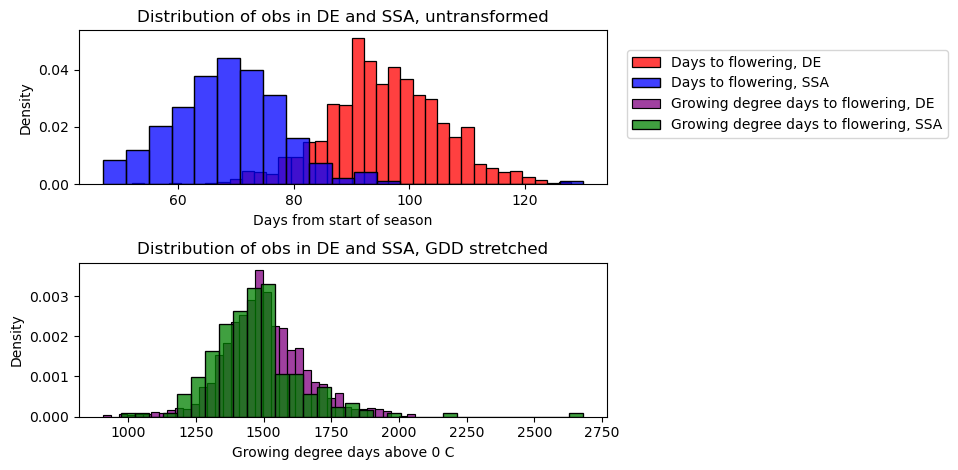

In [87]:
fig, axs = plt.subplots(2, 1)
sns.histplot(data = ds_inputs_DE, x = 'observed time to beginning of flowering', color='red', stat = 'density', ax = axs[0], label = 'Days to flowering, DE')
sns.histplot(data = ds_inputs_SSA, x = 'observed time to beginning of flowering', color='blue', stat = 'density', ax = axs[0], label = 'Days to flowering, SSA')

sns.histplot(data = ds_inputs_DE, x = 'observed time to beginning of flowering GDD', color='purple', stat = 'density', ax = axs[1], label = 'Growing degree days to flowering, DE')
sns.histplot(data = ds_inputs_SSA, x = 'observed time to beginning of flowering GDD', color='green', stat = 'density', ax = axs[1], label = 'Growing degree days to flowering, SSA')

axs[1].set_title('Distribution of obs in DE and SSA, GDD stretched')
axs[1].set_xlabel('Growing degree days above 0 C')
axs[0].set_title('Distribution of obs in DE and SSA, untransformed')
axs[0].set_xlabel('Days from start of season')

fig.legend(bbox_to_anchor = (1.5, 0.9))
fig.tight_layout()

In [74]:
ds_raw_DE['observed time to beginning of flowering']

19        94
20       104
21       106
22       106
23        98
        ... 
21500    102
21501    101
21519     93
21586    100
21588    122
Name: observed time to beginning of flowering, Length: 1719, dtype: object

In [97]:
ds_LSP_DE_1 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\GDD_time_MODIS_savgol_NDVI_DE.csv')

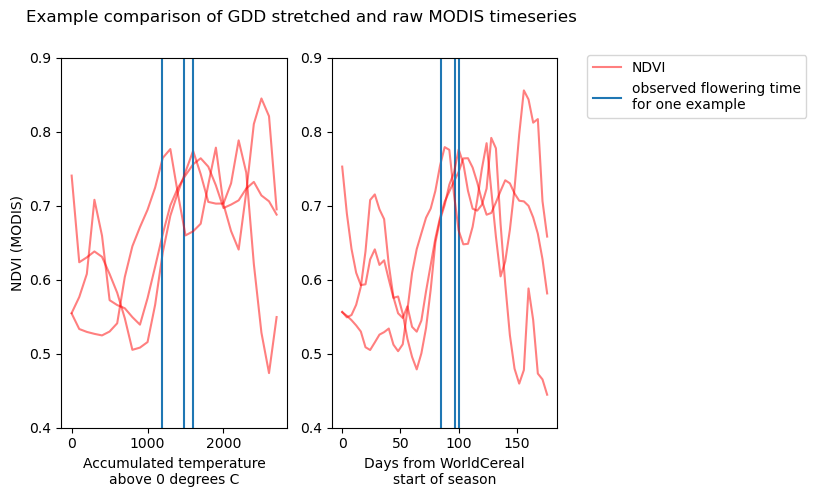

In [152]:
fig, axs = plt.subplots(1, 2)
first = True
for obs_index in ds_LSP_DE_1.index[[0, 2, 10]]:
    statid = ds_LSP_DE_1.loc[obs_index, 'Stations_id']
    year = ds_LSP_DE_1.loc[obs_index, 'year']
    GDD_at_year = ds_LSP_DE_1.loc[(ds_LSP_DE_1['Stations_id'] == statid)*(ds_LSP_DE_1['year'] == year)]
    raw_at_year = ds_inputs_DE.loc[(ds_inputs_DE['Stations_id'] == statid)*(ds_inputs_DE['year'] == year)]
    if first:
        axs[0].plot(range(0, 2800, 100), GDD_at_year[[f'NDVI at GDD {n}' for n in range(0, 2800, 100)]].values.squeeze(), alpha = 0.5, color = 'red', label = 'NDVI')
        axs[0].axvline(GDD_at_year['observed time to beginning of flowering GDD'].values, label = 'observed flowering time\nfor one example')
        first = False
    else:
        axs[0].plot(range(0, 2800, 100), GDD_at_year[[f'NDVI at GDD {n}' for n in range(0, 2800, 100)]].values.squeeze(), alpha = 0.5, color = 'red')
        axs[0].axvline(GDD_at_year['observed time to beginning of flowering GDD'].values)
    axs[1].plot(range(0, 180, 4), raw_at_year[[f'NDVI interpolated at day {n}' for n in range(0, 180, 4)]].values.squeeze(), alpha = 0.5, color = 'red')
    axs[1].axvline(raw_at_year['observed time to beginning of flowering'].values)

axs[0].set_xlabel('Accumulated temperature\nabove 0 degrees C')
axs[0].set_ylabel('NDVI (MODIS)')
axs[0].set_ylim(0.4, 0.9)
axs[1].set_xlabel('Days from WorldCereal\nstart of season')
axs[1].set_ylim(0.4, 0.9)
fig.suptitle('Example comparison of GDD stretched and raw MODIS timeseries')
fig.legend(bbox_to_anchor = (1.3, 0.9))
#axs[0].plot(range(0, 2800, 100), ds_LSP_DE_1.loc[0, [f'NDVI at GDD {n}' for n in range(0, 2800, 100)]])

In [109]:
(ds_LSP_DE_1['Stations_id'] == statid)

0        True
1        True
2       False
3       False
4       False
        ...  
1715    False
1716    False
1717    False
1718    False
1719    False
Name: Stations_id, Length: 1720, dtype: bool

In [4]:
ds_LSP_DE

,Unnamed: 0,year,Stations_Id,Day of start,NDVI interpolated at day 0,NDVI interpolated at day 8,NDVI interpolated at day 16,NDVI interpolated at day 24,NDVI interpolated at day 32,NDVI interpolated at day 40,...,NDVI interpolated at day 200,NDVI interpolated at day 208,NDVI interpolated at day 216,NDVI interpolated at day 224,NDVI interpolated at day 232,NDVI interpolated at day 240,NDVI interpolated at day 248,NDVI interpolated at day 256,NDVI interpolated at day 264,NDVI interpolated at day 272
0,0,2022,8053.0,2022-02-18,0.209935,0.204425,0.201276,0.200489,0.203290,0.206786,...,0.790636,0.734193,0.662695,0.582234,0.485862,0.374112,0.282993,0.238572,0.225904,0.244989
1,1,2022,7812.0,2022-02-18,0.384446,0.364882,0.337394,0.301981,0.232962,0.185263,...,0.644069,0.543343,0.465629,0.379222,0.297728,0.259116,0.297329,0.366404,0.483439,0.648434
2,2,2022,8348.0,2022-02-18,0.271136,0.248283,0.226978,0.207219,0.178528,0.167788,...,0.672326,0.576089,0.470115,0.382179,0.306967,0.250311,0.216180,0.191980,0.182512,0.187776
3,3,2022,8301.0,2022-02-18,0.381005,0.381169,0.378601,0.373300,0.350444,0.351834,...,0.677909,0.595590,0.494860,0.385563,0.316084,0.294628,0.325606,0.381935,0.473488,0.600265
4,4,2022,8135.0,2022-02-18,0.471341,0.473703,0.459910,0.429964,0.382632,0.317764,...,0.481263,0.387399,0.294027,0.253861,0.240588,0.272258,0.343226,0.384768,0.423788,0.460286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2080,63,2018,13959.0,2018-02-18,0.336557,0.311066,0.297602,0.296164,0.318663,0.343034,...,0.573283,0.487329,0.394641,0.321673,0.279545,0.271060,0.289106,0.304996,0.330593,0.365898
2081,64,2018,13950.0,2018-02-22,0.389022,0.325101,0.281724,0.258891,0.261597,0.280079,...,0.146436,0.146844,0.187985,0.272722,0.397842,0.551830,0.701764,0.805022,0.881894,0.932381
2082,65,2018,13949.0,2018-02-18,0.405729,0.393668,0.393065,0.403919,0.439856,0.499842,...,0.386917,0.276256,0.194001,0.155281,0.157534,0.206643,0.318778,0.406267,0.505979,0.617914
2083,66,2018,13938.0,2018-02-17,0.328518,0.286244,0.257844,0.243319,0.241970,0.262234,...,0.308231,0.282478,0.259376,0.246170,0.244527,0.241602,0.234041,0.239482,0.251141,0.269018


In [81]:
ds_reanalysis_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\Maize_ML_data2_t2m.csv') #_60D_Offset
#ds_reanalysis_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\Maize_ML_data2_t2m.csv')
ds_reanalysis_DE = ds_reanalysis_DE.drop('Unnamed: 0', axis = 1)#read_reanalysis()
ds_reanalysis_DE = ds_reanalysis_DE.rename(columns={'Stations_id': 'Stations_Id', 'Referenzjahr': 'year'})
ds_reanalysis_DE['year'] = ds_reanalysis_DE['year'].astype(int)
#ds_LSP_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\LSP_savgol_raw_MODIS_DE.csv')#_60_offset
#ds_LSP_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\GDD_time_MODIS_savgol_NDVI_DE.csv')
#ds_LSP_DE = ds_LSP_DE.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1).rename(columns={'Stations_id': 'Stations_Id'})
ds_LSP_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_savgol_raw_8window_MODIS_DE_with_mask.csv')
#ds_LSP_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_savgol_raw_sentinel.csv')
ds_inputs_DE = pd.merge(ds_LSP_DE, ds_reanalysis_DE, on=['Stations_Id', 'year'], how='outer')
ds_inputs_DE = ds_inputs_DE.rename(columns={'Stations_Id': 'Stations_id'})
ds_inputs_DE = loc_and_SOS(ds_inputs_DE, predictor_type='savgol_raw').dropna()
with warnings.catch_warnings(action="ignore"):
    ds_inputs_DE = interpolate_columns(ds_inputs_DE, 270, 'NDVI', resolution=8)
ds_inputs_DE.loc[:, [f't2m at day {n}' for n in range(200)]] = modelling_fctns.Wang_Engel_Temp_response(ds_inputs_DE.loc[:, [f't2m at day {n}' for n in range(200)]], 7, 28, 42)
ds_inputs_DE = make_cumulative(ds_inputs_DE, driver_variable = 't2m', numdays = 200, T_base = 0)
for phase in ['beginning of emergence', 'beginning of flowering', 'yellow ripeness']:
    ds_inputs_DE.loc[:, f'observed time to {phase}'] = pd.to_timedelta(ds_inputs_DE.loc[:, f'observed time to {phase}']).dt.days
ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['observed time to beginning of flowering'] > 0]
ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['NDVI interpolated at day 0'] >= 0]
#ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['NDVI at GDD 0'] >= 0]
#offset_sample = np.int64(truncnorm.rvs(-1, 1, size=len(ds_inputs_DE))*30) + 30
#resamples = ds_inputs_DE.reset_index().apply(lambda row: offset_dates(row, offset_sample), axis=1)#[0]

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_21736\2104312202.py:98: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


In [78]:
ds_inputs_DE[['Day of start', 'WC SOS date']]
#ds_inputs_DE.loc[pd.to_datetime(ds_inputs_DE['Day of start']) - pd.to_datetime(ds_inputs_DE['WC SOS date']) == np.timedelta64(-57, 'D')]

,Day of start,WC SOS date
6,2007-02-14,2007-04-15
7,2008-02-14,2008-04-14
8,2009-02-14,2009-04-15
9,2010-02-14,2010-04-15
10,2011-02-14,2011-04-15
...,...,...
32159,2014-02-18,2014-04-18
32163,2018-02-18,2018-04-18
32165,2020-02-18,2020-04-17
32168,2023-02-18,2023-04-18


In [ ]:
fig, ax = plt.subplots()
ds = ds_inputs_DE.loc[ds_inputs_DE['year'] == 2020].iloc[10:13, :]
plot_ts_and_phen(ds, fig, ax)
offset_sample = np.int64(truncnorm.rvs(-1, 1, size=len(ds))*30) + 30
shifted = ds.reset_index().apply(lambda row: offset_dates(row, offset_sample), axis=1)#[0]
fig, ax = plt.subplots()
plot_ts_and_phen(shifted, fig, ax, numdays = 200)

<Axes: xlabel='observed time to beginning of flowering', ylabel='Count'>

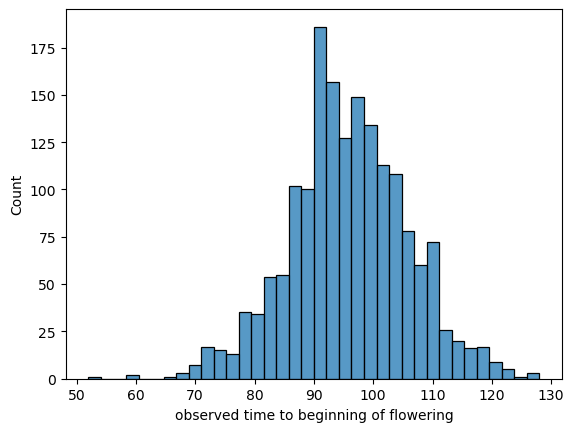

In [6]:
sns.histplot(ds_inputs_DE['observed time to beginning of flowering'])

In [ ]:
#ds_inputs_DE['WC SOS date'] + pd.to_timedelta(np.random.normal(0, 30, ), 'D')#.shape
#pd.DataFrame(columns=[f'NDVI interpolated at day {n}' for n in range(190)] + [f't2m at day {n}' for n in range(190)] + ['observed time to beginning of emergence',
#                                                                                                                        'observed time to beginning of flowering',
#                                                                                                                        'observed time to yellow ripeness',
#                                                                                                                        'lat',
#                                                                                                                        'lon',
#                                                                                                                        'year',
#                                                                                                                        'Stations_id',
#                                                                                                                        'Day of start'])
#ds_inputs_DE.loc[:, f'observed time to yellow ripeness'] 

In [127]:
ds_inputs_DE['t2m at day 100']#['observed time to beginning of flowering']#[['Day of start', 'WC SOS date']]

19       1636.034848
20       1449.893222
21       1369.242637
22       1417.258282
23       1425.999809
            ...     
21500    1470.041978
21501    1498.472620
21519    1590.197341
21586    1664.159296
21588    1392.277487
Name: t2m at day 100, Length: 1720, dtype: float64

In [82]:
skip = 1
numsteps = int(183 // skip)
NDVI_series_DE = torch.Tensor(ds_inputs_DE[[f'NDVI interpolated at day {56 + skip*n}' for n in range(numsteps)]].values)#12
#NDVI_series_DE = ((NDVI_series_DE - NDVI_series_DE.min(dim=1)[0].unsqueeze(1))/(NDVI_series_DE.max(dim=1)[0] - NDVI_series_DE.min(dim=1)[0]).unsqueeze(1))
temp_series_DE = torch.Tensor(ds_inputs_DE[[f't2m at day {skip*n}' for n in range(numsteps)]].values)
temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, NDVI_series_DE)), 0, 1)
NDVI_labels_DE = torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].astype('int64').values)

In [83]:
skip = 1
numsteps = int(183 // skip)
NDVI_series_SSA = torch.Tensor(ds_inputs_SSA[[f'NDVI interpolated at day {skip*n}' for n in range(numsteps)]].values)#12
#NDVI_series_SSA = ((NDVI_series_SSA - NDVI_series_SSA.min(dim=1)[0].unsqueeze(1))/(NDVI_series_SSA.max(dim=1)[0] - NDVI_series_SSA.min(dim=1)[0]).unsqueeze(1))
temp_series_SSA = torch.Tensor(ds_inputs_SSA[[f'temperature at day {skip*n}' for n in range(numsteps)]].values)
temp_NDVI_series_SSA = torch.swapaxes(torch.stack((temp_series_SSA, NDVI_series_SSA)), 0, 1)
NDVI_labels_SSA = torch.Tensor(ds_inputs_SSA['observed time to beginning of flowering'].astype('int64').values)

In [66]:
skip = 4
numsteps = int(263 // skip) #int(203 // skip)
NDVI_series_DE = torch.Tensor(just_NDVI[[f'NDVI interpolated at day {8 + skip*n}' for n in range(numsteps)]].values)#12
NDVI_series_DE = ((NDVI_series_DE - NDVI_series_DE.min(dim=1)[0].unsqueeze(1))/(NDVI_series_DE.max(dim=1)[0] - NDVI_series_DE.min(dim=1)[0]).unsqueeze(1))
#NDVI_labels_DE = torch.Tensor(just_NDVI['observed time to beginning of flowering'].astype('int64').values)
NDVI_labels_DE = torch.Tensor(just_NDVI['observed time to yellow ripeness'].astype('int64').values)

In [39]:
NDVI_series_DE.shape

torch.Size([10019, 45])

In [89]:
NDVI_series_DE = torch.Tensor(ds_inputs_DE[[f'NDVI at GDD {n}' for n in range(0, 2400, 100)]].values)
#NDVI_series_DE = ((NDVI_series_DE - NDVI_series_DE.min(dim=1)[0].unsqueeze(1))/(NDVI_series_DE.max(dim=1)[0] - NDVI_series_DE.min(dim=1)[0]).unsqueeze(1))
NDVI_labels_DE = torch.Tensor(ds_inputs_DE['observed time to beginning of flowering GDD'].values)

In [55]:
NDVI_series_SSA = torch.Tensor(ds_inputs_SSA[[f'NDVI at GDD {n}' for n in range(0, 2200, 100)]].values)
NDVI_series_SSA = ((NDVI_series_SSA - NDVI_series_SSA.min(dim=1)[0].unsqueeze(1))/(NDVI_series_SSA.max(dim=1)[0] - NDVI_series_SSA.min(dim=1)[0]).unsqueeze(1))
NDVI_labels_SSA = torch.Tensor(ds_inputs_SSA['observed time to beginning of flowering GDD'].values)

In [11]:
NDVI_series_SSA = torch.Tensor(ds_inputs_SSA[[f'NDVI interpolated at day {n}' for n in range(195)]].values)
temp_series_SSA = torch.Tensor(ds_inputs_SSA[[f'temperature at day {n}' for n in range(195)]].values)
temp_NDVI_series_SSA = torch.swapaxes(torch.stack((temp_series_SSA, NDVI_series_SSA)), 0, 1)
NDVI_labels_SSA = torch.Tensor(ds_inputs_SSA['observed time to beginning of flowering'].values)

In [55]:
class phen_CNN_1d(nn.Module):
    #def __init__(self):
    #    super().__init__()
        

    #def forward(self, xb):
    #    return self.lin(xb)
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(2, 3, kernel_size=9, padding=4)
        self.conv2 = nn.Conv1d(3, 3, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(3, 1, kernel_size=3, padding=1)
        self.lin = nn.Linear(40, 1)
        self.pool = torch.nn.AvgPool1d(kernel_size=183, padding = 0)
    
    def forward(self, xb):
        #print(xb[0, 0, :])
        xb = torch.nn.functional.leaky_relu(self.conv1(xb), negative_slope=0.001)
        #print(xb[0, 0, :])
        #xb = torch.nn.functional.leaky_relu(self.conv2(xb), negative_slope=0.001)
        #print(xb[0, 0, :])
        xb = torch.nn.functional.leaky_relu(self.conv3(xb), negative_slope=0.001)
        #xb = torch.nn.functional.relu(self.conv3(xb))
        #print(xb[0, :])
        xb = self.pool(xb)
        #print(xb[0, :, :])
        #print(xb[0, :])
        return xb.view(-1, xb.size(1))

def get_model():
    model = phen_CNN_1d()
    return model, optim.SGD(model.parameters(), lr=lr)

def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = torch.sqrt(loss_func(model(xb), yb))

    if opt is not None:
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 100)
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def plot_train_val_loss(num_epochs, train_losses, val_losses, best_epoch):

    epochs = range(1, num_epochs + 1)
    # Plot Losses
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(epochs, train_losses, label='Train Loss')
    ax.plot(epochs, val_losses, label='Val Loss')
    ax.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Epoch ({best_epoch})')
    fig.suptitle('Loss vs Epoch')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ymax = min((np.array(val_losses)[:20].max())*1.05, 40)
    ymin = (np.array(val_losses).min())*0.95
    ax.set_ylim([ymin, ymax])
    plt.legend()

    # Show the plots
    plt.tight_layout()

def dl_variance(dl):
    running_var = 0
    running_len = 0
    for xb, yb in dl:
        running_var += torch.var(yb)*(len(yb) - 1)
        running_len += len(yb)
    return running_var/(running_len - 1)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl, save_name = 'best_model'):
    # Variables to store training history
    train_losses = []
    val_losses = []
    best_loss = 10000
    best_epoch = 0
    
    train_var = dl_variance(train_dl)
    val_var = dl_variance(valid_dl)

    for epoch in range(epochs):
        running_loss = 0.0
        running_samples = 0
        model.train()
        running_var = 0
        running_var_val = 0

        for xb, yb in train_dl:
            batch_loss, batch_len = loss_batch(model, loss_func, xb, yb, opt)
            #print(batch_loss**2
            running_loss += (batch_loss**2)*batch_len
            running_samples += batch_len
            
            #print(batch_loss, batch_len, running_samples)
        train_loss = np.sqrt(running_loss/running_samples)
        
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
            
        val_loss = np.sqrt(np.sum(np.multiply(np.power(losses, 2), nums)) / np.sum(nums))

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        # Save the best model (based on validation accuracy)
        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch = epoch + 1
            best_model_state = deepcopy(model.state_dict())

        #Save the model at the last epoch
        if epoch == epochs - 1:
            #torch.save(model.state_dict(), 'saved_models/last_test.pth')
            model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
            model_path = os.path.join(model_dir, save_name + ".pt")
            #torch.save(model.state_dict(), model_path)
            torch.save({'epoch': best_epoch, 'model_state_dict': best_model_state}, model_path)
        if epoch % 5 == 0:
            train_r2 = 1 - ((train_loss**2)/train_var)
            val_r2 = 1 - ((val_loss**2)/val_var)
            print(epoch, train_loss, val_loss)
            print(f'R2 on train set: {train_r2}\nR2 on test set: {val_r2}')
    plot_train_val_loss(epochs, train_losses, val_losses, best_epoch)

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))

def preprocess(x, y, channels = 1):
    if channels == 1:
        return x[:, None, :], y.view(-1, 1)
    else:
        return x, y.view(-1, 1)

def train_test_dl_from_tensors(x_train, y_train, bs = 500, n_channels=1, train_proportion = 0.8):
    full_ds = TensorDataset(x_train, y_train)
    train_size = int(train_proportion * len(full_ds))
    val_size = len(full_ds) - train_size
    train_ds, val_ds = random_split(full_ds, [train_size, val_size])
    train_dl = DataLoader(train_ds, batch_size=bs)
    val_dl = DataLoader(val_ds, batch_size=bs)
    train_dl = WrappedDataLoader(train_dl, lambda x, y: preprocess(x, y, channels =n_channels))
    val_dl = WrappedDataLoader(val_dl, lambda x, y: preprocess(x, y, channels =n_channels))
    return train_dl, val_dl

def plot_fitted_observed(TS_model, dl):
    list_fitted = []
    list_observed = []
    for xb, yb in dl:
        with torch.no_grad():
            list_fitted.append(TS_model(xb))
        list_observed.append(yb)
    fitted = torch.cat(list_fitted)
    observed = torch.cat(list_observed)
    comparison_frame = pd.DataFrame({'fitted': fitted.numpy().squeeze(), 'observed': observed.numpy().squeeze()})
    maxval = max(comparison_frame['fitted'].max(), comparison_frame['observed'].max())
    minval = min(comparison_frame['fitted'].min(), comparison_frame['observed'].min())
    fig, ax = plt.subplots()
    sns.regplot(x='fitted', y='observed', data = comparison_frame, ax=ax,
                scatter_kws={'alpha':0.5, 's':4},  x_bins=np.arange(minval - 5, maxval + 5, 3))
    ax.plot([minval, maxval], [minval, maxval], linestyle = '--', color='k')
    rsquared = r2_score(comparison_frame['observed'], comparison_frame['fitted'])
    print(f'R^2 value for model: {rsquared}')
    bias = comparison_frame['observed'].mean() - comparison_frame['fitted'].mean()
    variance_modelled = comparison_frame[f'fitted'].var()
    print(f'Bias: {bias**2}\nVariance of modelled values: {variance_modelled}')

In [99]:
bs = 2000
n_channels = 2
train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels)

In [57]:
bs = 2000
n_channels = 1
skip = 4
numsteps = int(199 // skip)
temp_series_DE = torch.Tensor(ds_inputs_DE[[f't2m at day {n*skip}' for n in range(numsteps)]].values)
train_dl, val_dl = train_test_dl_from_tensors(temp_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels)

In [89]:
bs = 500
n_channels = 1
train_dl, val_dl = train_test_dl_from_tensors(NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels)

0 98.26126861572266 99.43742370605469
R2 on train set: -82.89531707763672
R2 on test set: -86.38269805908203
5 97.85405731201172 98.91943359375
R2 on train set: -82.20140838623047
R2 on test set: -85.47468566894531
10 96.95965576171875 97.92998504638672
R2 on train set: -80.68740844726562
R2 on test set: -83.75340270996094
15 95.54165649414062 96.36222839355469
R2 on train set: -78.31558227539062
R2 on test set: -81.06149291992188
20 92.66889953613281 92.79093170166016
R2 on train set: -73.6175537109375
R2 on test set: -75.09162139892578
25 32.402400970458984 5258.634765625
R2 on train set: -8.122783660888672
R2 on test set: -244382.4375
30 98.01111602783203 61.85825729370117
R2 on train set: -82.46869659423828
R2 on test set: -32.815914154052734
35 102.40538024902344 105.77470397949219
R2 on train set: -90.12100982666016
R2 on test set: -97.87565612792969
40 105.34439086914062 104.41588592529297
R2 on train set: -95.4263687133789
R2 on test set: -95.35159301757812
45 158.5607757568359

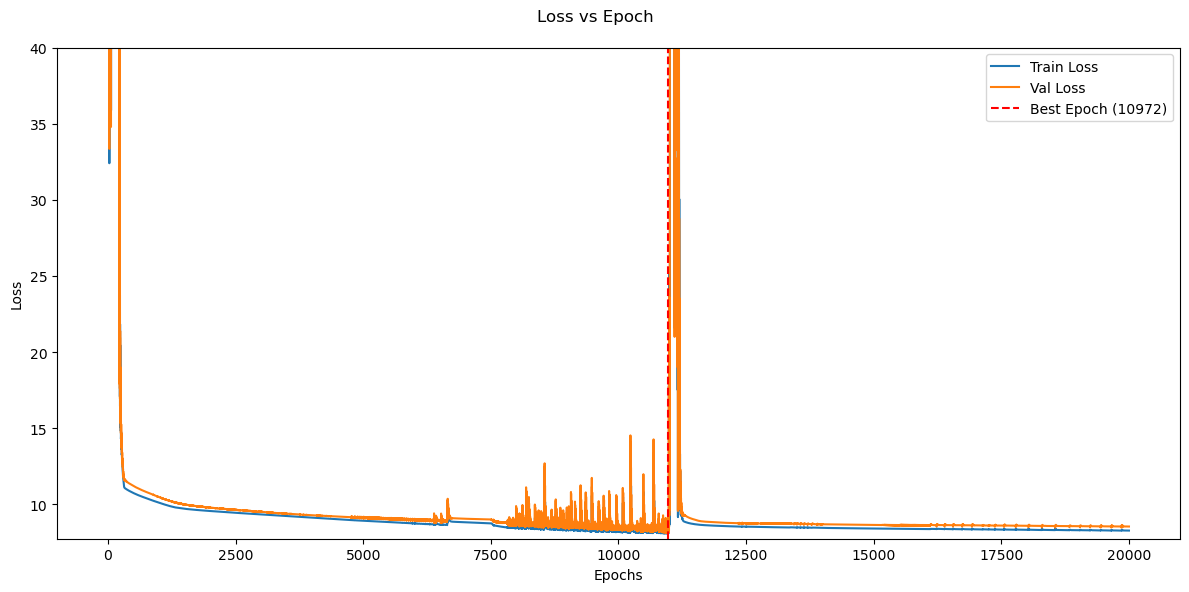

In [21]:
bs = 2000
n_channels = 2
train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels)
model = nn.Sequential(
#    Lambda(preprocess),
    nn.Conv1d(n_channels, 3, kernel_size=5, dilation=6, padding=12),#stride=3, 
    nn.LeakyReLU(negative_slope=0.01),
#    nn.Conv1d(3, 3, kernel_size=3, padding=1),
#    nn.LeakyReLU(negative_slope=0.01),
    nn.Conv1d(3, 1, kernel_size=3, padding=1),
    nn.LeakyReLU(negative_slope=0.01),
    nn.AdaptiveAvgPool1d(1),#nn.Linear(numsteps, 1)#
    Lambda(lambda x: x.view(x.size(0), -1)),
)
model = nn.Sequential(
#    Lambda(preprocess),
    nn.Conv1d(n_channels, 3, kernel_size=3, dilation=1, padding=12),#stride=3, 
    nn.LeakyReLU(negative_slope=0.01),
    nn.AvgPool1d(kernel_size=3),
    nn.Conv1d(3, 3, kernel_size=3, padding=2),
    nn.LeakyReLU(negative_slope=0.01),
    nn.MaxPool1d(kernel_size=3),
    nn.Conv1d(3, 3, kernel_size=3, padding=1),
    nn.LeakyReLU(negative_slope=0.01),
    nn.AvgPool1d(kernel_size=3),
    nn.Flatten(),
    nn.Linear(6, 1),
    nn.LeakyReLU(negative_slope=0.01),
    #nn.AdaptiveAvgPool1d(1),
    #Lambda(lambda x: x.view(x.size(0), -1)),
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

lr = 0.03
#model = phen_CNN_1d()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
#opt = optim.Adam(model.parameters(), lr=lr)
epochs = 20000
loss_func = F.mse_loss
fit(epochs, model, loss_func, opt, train_dl, val_dl, save_name='temp_and_NDVI')

R^2 value for model: 0.10036206245422363
Bias: 1.8609495842829347
Variance of modelled values: 10.677059173583984


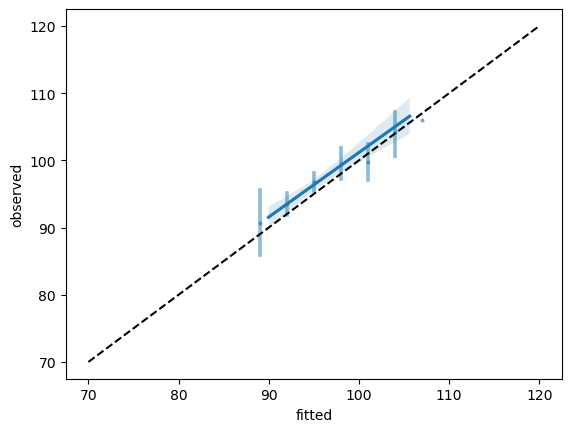

In [48]:
#train_dl, val_dl = train_test_dl_from_tensors(temp_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels)
model2 = nn.Sequential(
#    Lambda(preprocess),
    nn.Conv1d(n_channels, 2, kernel_size=5, dilation=6, padding=12),#stride=3, 
    nn.LeakyReLU(negative_slope=0.01),
#    nn.Conv1d(3, 3, kernel_size=3, padding=1),
#    nn.LeakyReLU(negative_slope=0.01),
    nn.Conv1d(2, 1, kernel_size=3, padding=1),
    nn.LeakyReLU(negative_slope=0.01),
    nn.AdaptiveAvgPool1d(1),#nn.Linear(numsteps, 1)#
    Lambda(lambda x: x.view(x.size(0), -1)),
) 

model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
model_path = os.path.join(model_dir, 'NDVI_CNN' + ".pt")

checkpoint = torch.load(model_path, weights_only=True)
model2.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
plot_fitted_observed(model2, val_dl)

In [57]:
def plot_from_saved(savename, model, val_dl):
    model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
    model_path = os.path.join(model_dir, savename + ".pt")
    checkpoint = torch.load(model_path, weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    plot_fitted_observed(model, val_dl)

In [81]:
torchinfo.summary(model)#.eval()

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Conv1d: 1-1                            11
├─LeakyReLU: 1-2                         --
├─Conv1d: 1-3                            4
├─LeakyReLU: 1-4                         --
├─AdaptiveAvgPool1d: 1-5                 --
├─Lambda: 1-6                            --
Total params: 15
Trainable params: 15
Non-trainable params: 0

In [82]:
for name, param in model.named_parameters():
    print(f"Parameter name: {name}")
    print(f"Parameter value: {param}")

Parameter name: 0.weight
Parameter value: Parameter containing:
tensor([[[  7.1422,  -2.4835,  -2.7349,   1.2524,  -4.4099],
         [  5.1709,  -0.2092, -10.8349,  -1.1365,  -3.4423]]],
       requires_grad=True)
Parameter name: 0.bias
Parameter value: Parameter containing:
tensor([-40.6502], requires_grad=True)
Parameter name: 2.weight
Parameter value: Parameter containing:
tensor([[[-2.5403, -1.5112, -0.5888]]], requires_grad=True)
Parameter name: 2.bias
Parameter value: Parameter containing:
tensor([111.1209], requires_grad=True)


In [44]:
C1 = list(model.children())[0]
RU1 = list(model.children())[1]
C2 = list(model.children())[2]
RU2 = list(model.children())[3]
AP = list(model.children())[4]

In [92]:
def plot_all_channels(X, fig, ax):
    for channel_index in range(X.shape[0]):
        ax.plot(X[channel_index, :])

In [93]:
def plot_each_layer(TS_model, X):
    layers = list(TS_model.children())
    fig, axs = plt.subplots(len(layers) + 1, 1, figsize = (3, 10))
    plot_all_channels(X, fig, axs[0])
    X_at_layer = X
    for layer_index, layer in enumerate(layers):
        ax = axs[layer_index + 1]
        with torch.no_grad():
            X_at_layer = layer(X_at_layer)
        plot_all_channels(X_at_layer, fig, ax)


In [51]:
X = temp_NDVI_series_DE[0, :, :]
X.shape

torch.Size([2, 45])

In [158]:
NDVI_series_DE.shape

torch.Size([1720, 45])

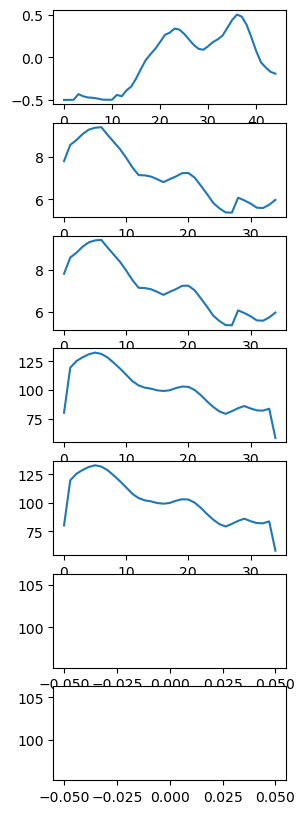

In [138]:
plot_each_layer(model, NDVI_series_DE.view(-1, 1, 45)[14, :, :] - 0.5)

In [72]:
with torch.no_grad():
    print(AP(RU2(C2(RU1(C1(temp_NDVI_series_DE[0, :, :]))))))

tensor([[91.1205]])


In [74]:
bs = 2000
n_channels = 1
train_dl, val_dl = train_test_dl_from_tensors(temp_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels)
model = nn.Sequential(
#    Lambda(preprocess),
    nn.Conv1d(n_channels, 3, kernel_size=5, dilation=2, padding=12),#stride=3, 
    nn.LeakyReLU(negative_slope=0.01),
    nn.MaxPool1d(kernel_size=3),
    nn.Conv1d(3, 3, kernel_size=3, padding=2),
    nn.LeakyReLU(negative_slope=0.01),
    nn.MaxPool1d(kernel_size=3),
    nn.Conv1d(3, 2, kernel_size=3, padding=1),
    nn.LeakyReLU(negative_slope=0.01),
    nn.MaxPool1d(kernel_size=3),
    nn.Flatten(),
    nn.Linear(14, 1),
    nn.LeakyReLU(negative_slope=0.01),
    #nn.AdaptiveAvgPool1d(1),
    #Lambda(lambda x: x.view(x.size(0), -1)),
)
lr = 0.05
#model = phen_CNN_1d()
#opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
opt = optim.Adam(model.parameters(), lr=lr)
epochs = 2000
loss_func = F.mse_loss
fit(epochs, model, loss_func, opt, train_dl, val_dl, save_name='temp_CNN3')

0 96.3759765625 95.14257049560547
R2 on train set: -94.03227996826172
R2 on test set: -80.09221649169922
5 91.90216827392578 88.27229309082031
R2 on train set: -85.41419219970703
R2 on test set: -68.80366516113281
10 61.98743438720703 47.914146423339844
R2 on train set: -38.31342697143555
R2 on test set: -19.566335678100586
15 40.97872543334961 43.3973388671875
R2 on train set: -16.181079864501953
R2 on test set: -15.871574401855469
20 21.55540657043457 25.52361297607422
R2 on train set: -3.7538557052612305
R2 on test set: -4.835978984832764
25 20.661863327026367 17.69430160522461
R2 on train set: -3.367898464202881
R2 on test set: -1.8047637939453125
30 20.135929107666016 18.235618591308594
R2 on train set: -3.148364543914795
R2 on test set: -1.978999376296997
35 17.746620178222656 16.357519149780273
R2 on train set: -2.222291946411133
R2 on test set: -1.3969793319702148
40 15.894159317016602 15.654887199401855
R2 on train set: -1.5846912860870361
R2 on test set: -1.195479154586792
45

KeyboardInterrupt: 

R^2 value for model: -0.34430789947509766
Bias: 49.77136073321162
Variance of modelled values: 113.59953308105469


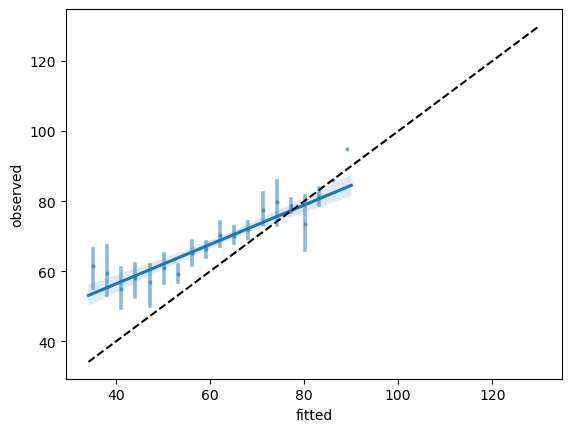

In [77]:
train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(temp_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0)
plot_from_saved('Temp_CNN2', model, val_dl_SSA)

In [ ]:
model = nn.Sequential(
#    Lambda(preprocess),
    nn.Conv1d(n_channels, 2, kernel_size=5, dilation=6, padding=7),#stride=3, 
    nn.LeakyReLU(negative_slope=0.01),
    #nn.Conv1d(3, 3, kernel_size=3, padding=1),
    #nn.LeakyReLU(negative_slope=0.01),
    nn.Conv1d(2, 1, kernel_size=3, padding=1),
    nn.LeakyReLU(negative_slope=0.01),
    nn.AdaptiveAvgPool1d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

R^2 value for model: 0.3563251495361328
Bias: 0.4535612259642221
Variance of modelled values: 35.384422302246094


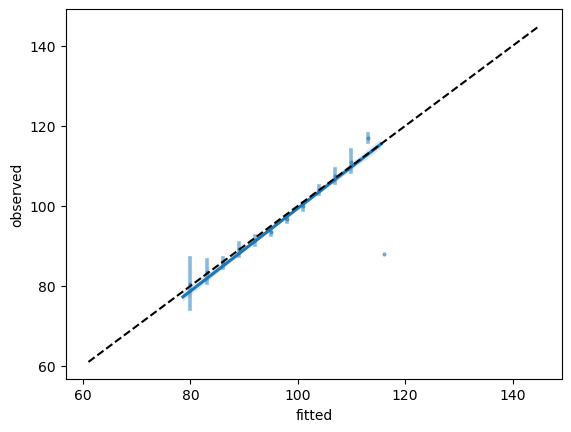

In [92]:
plot_from_saved('Temp_NDVI_CNN', model, val_dl)

In [82]:
temp_series_DE.shape

torch.Size([9838, 183])

0 94.57984178609719 29.34539805592538
R2 on train set: -80.14273071289062
R2 on test set: -7.20781135559082
5 16.451044561271104 15.461612246929407
R2 on train set: -1.4549317359924316
R2 on test set: -1.278541088104248
10 14.828848336445686 13.827132058058394
R2 on train set: -0.9946527481079102
R2 on test set: -0.8222650289535522
15 14.304391660561063 13.048982705051483
R2 on train set: -0.8560565710067749
R2 on test set: -0.6229332685470581
20 12.757957346148244 12.030706881095904
R2 on train set: -0.4764363765716553
R2 on test set: -0.37952518463134766
25 10.988952002492718 10.461069961271257
R2 on train set: -0.09538042545318604
R2 on test set: -0.043036580085754395
30 9.820164851261627 9.205031899525311
R2 on train set: 0.1252378225326538
R2 on test set: 0.19239699840545654
35 9.294203702368293 8.674135021500847
R2 on train set: 0.21643173694610596
R2 on test set: 0.28286707401275635
40 9.382385435657163 8.748775921735467
R2 on train set: 0.20149248838424683
R2 on test set: 0.270

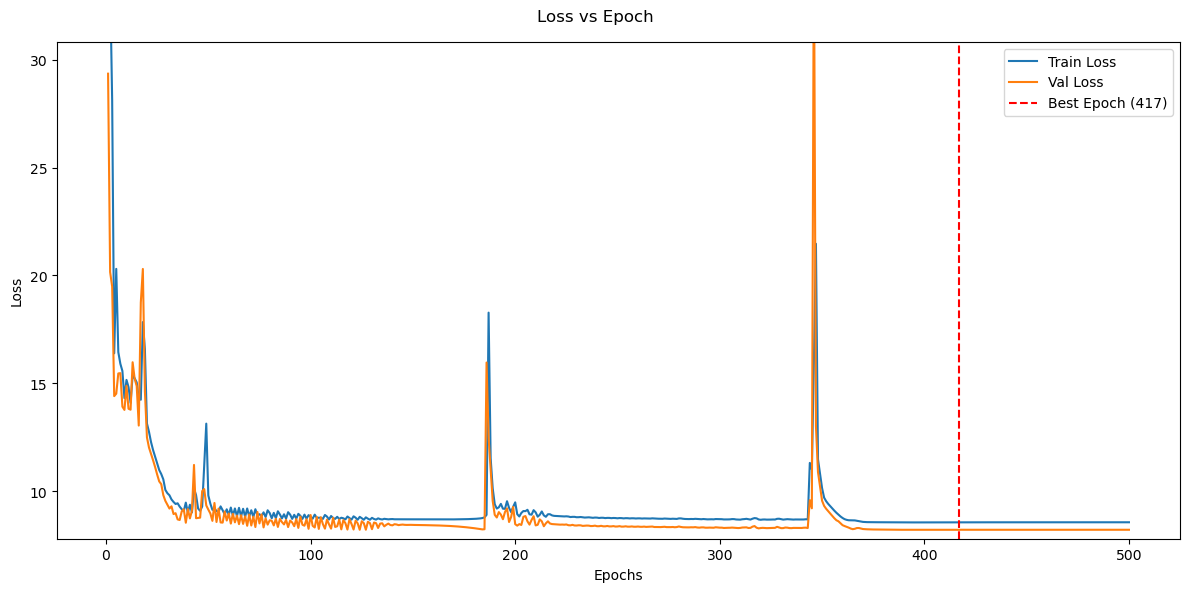

In [91]:
bs = 500
n_channels = 2
train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels)# - 0.5
model = nn.Sequential(
#    Lambda(preprocess),
    nn.Conv1d(n_channels, 3, kernel_size=3, dilation=1, padding=12),#stride=3, 
    nn.LeakyReLU(negative_slope=0.01),
    nn.AvgPool1d(kernel_size=3),
    nn.Conv1d(3, 3, kernel_size=3, padding=2),
    nn.LeakyReLU(negative_slope=0.01),
    nn.MaxPool1d(kernel_size=3),
    nn.Conv1d(3, 3, kernel_size=3, padding=1),
    nn.LeakyReLU(negative_slope=0.01),
    nn.AvgPool1d(kernel_size=3),
    nn.Flatten(),
    nn.Linear(21, 1),
    nn.LeakyReLU(negative_slope=0.01),
    #nn.AdaptiveAvgPool1d(1),
    #Lambda(lambda x: x.view(x.size(0), -1)),
)
lr = 0.1
#model = phen_CNN_1d()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
opt = optim.Adam(model.parameters(), lr=lr)
epochs = 500
loss_func = F.mse_loss
fit(epochs, model, loss_func, opt, train_dl, val_dl, save_name='Temp_NDVI_CNN')

0 60.200835434966955 18.4763675146967
R2 on train set: -27.972702026367188
R2 on test set: -1.8489456176757812
5 11.149294478004627 10.884534341881244
R2 on train set: 0.006246328353881836
R2 on test set: 0.011285960674285889
10 11.245502470424938 11.10874180287785
R2 on train set: -0.010977983474731445
R2 on test set: -0.02986598014831543
15 11.322213032041514 11.220391877760703
R2 on train set: -0.024817705154418945
R2 on test set: -0.05067169666290283
20 11.316266938790113 11.2133181334197
R2 on train set: -0.023741483688354492
R2 on test set: -0.0493474006652832
25 11.305457669006266 11.19676808216466
R2 on train set: -0.02178668975830078
R2 on test set: -0.04625213146209717
30 11.292901294969118 11.174815199449975
R2 on train set: -0.019518256187438965
R2 on test set: -0.04215347766876221
35 11.279187108289934 11.154374459780579
R2 on train set: -0.017043590545654297
R2 on test set: -0.038344383239746094
40 11.263465125092013 11.126725699325208
R2 on train set: -0.0142102241516113

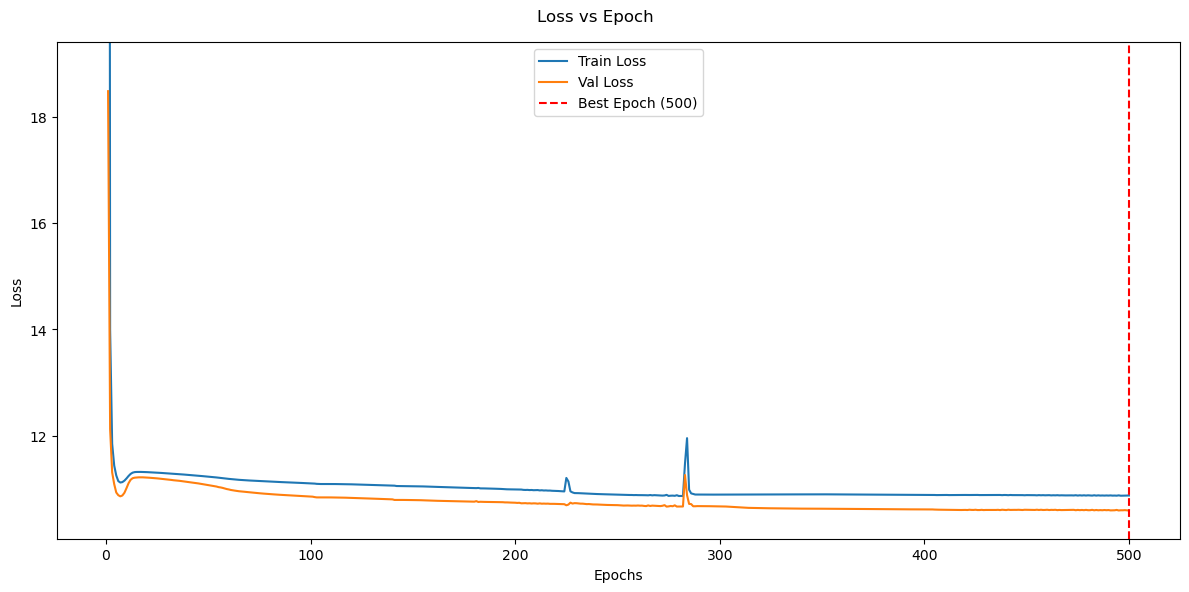

In [67]:
bs = 500
n_channels = 1
train_dl, val_dl = train_test_dl_from_tensors(NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels)# - 0.5
model = nn.Sequential(
#    Lambda(preprocess),
    nn.Conv1d(n_channels, 3, kernel_size=3, dilation=1, padding=12),#stride=3, 
    nn.LeakyReLU(negative_slope=0.01),
    nn.AvgPool1d(kernel_size=3),
    nn.Conv1d(3, 3, kernel_size=3, padding=2),
    nn.LeakyReLU(negative_slope=0.01),
    nn.MaxPool1d(kernel_size=3),
    nn.Conv1d(3, 3, kernel_size=3, padding=1),
    nn.LeakyReLU(negative_slope=0.01),
    nn.AvgPool1d(kernel_size=3),
    nn.Flatten(),
    nn.Linear(9, 1),
    nn.LeakyReLU(negative_slope=0.01),
    #nn.AdaptiveAvgPool1d(1),
    #Lambda(lambda x: x.view(x.size(0), -1)),
)
lr = 0.1
#model = phen_CNN_1d()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
opt = optim.Adam(model.parameters(), lr=lr)
epochs = 500
loss_func = F.mse_loss
fit(epochs, model, loss_func, opt, train_dl, val_dl, save_name='GDD_NDVI_CNN')

In [33]:
NDVI_series_DE.shape

torch.Size([2380, 65])

0 98.18644301962925 96.3691635131836
R2 on train set: -80.85773468017578
R2 on test set: -77.05242919921875
5 41.90771146395453 15.667854309082031
R2 on train set: -13.912298202514648
R2 on test set: -1.0631427764892578
10 22.35223292423864 14.289529800415039
R2 on train set: -3.24227237701416
R2 on test set: -0.7161139249801636
15 14.279389490593287 11.121830940246582
R2 on train set: -0.7313146591186523
R2 on test set: -0.03959167003631592
20 10.480188671262205 12.281865119934082
R2 on train set: 0.06740105152130127
R2 on test set: -0.2677654027938843
25 10.795738721815766 10.856291770935059
R2 on train set: 0.010396003723144531
R2 on test set: 0.009457170963287354
30 10.290813680222124 10.92855167388916
R2 on train set: 0.10080033540725708
R2 on test set: -0.0037728548049926758
35 10.127608115329272 10.82460880279541
R2 on train set: 0.12909561395645142
R2 on test set: 0.015230357646942139
40 10.032753157642974 10.760037422180176
R2 on train set: 0.145332932472229
R2 on test set: 0.

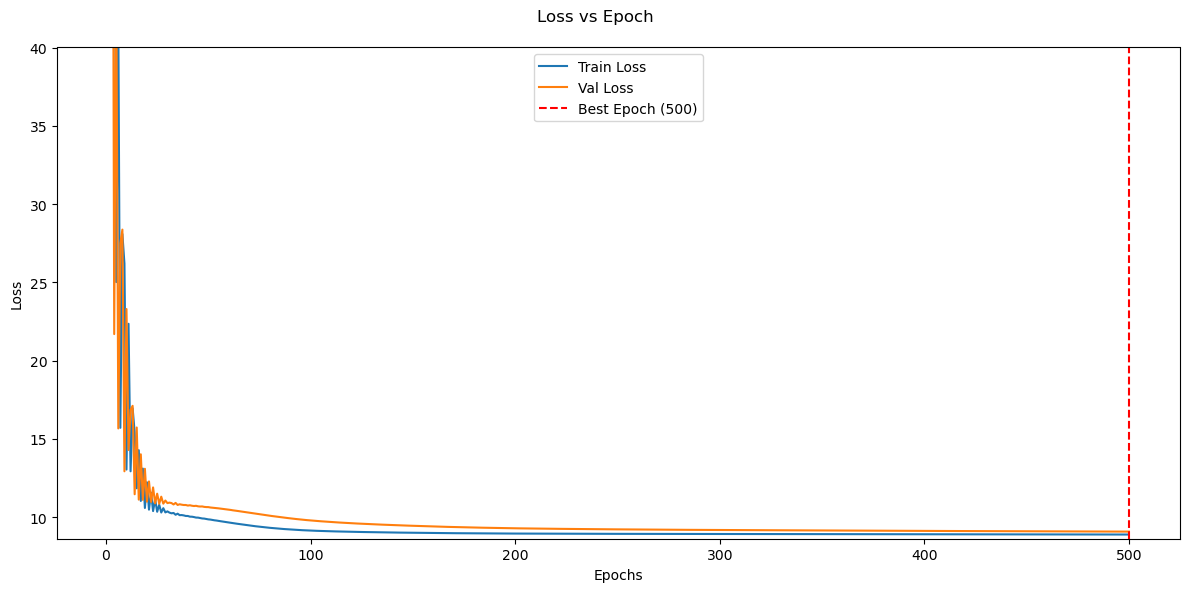

In [16]:
bs = 500
n_channels = 1
train_dl, val_dl = train_test_dl_from_tensors(NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels)# - 0.5
model = nn.Sequential(
#    Lambda(preprocess),
    nn.Conv1d(n_channels, 3, kernel_size=3, dilation=1, padding=12),#stride=3, 
    nn.LeakyReLU(negative_slope=0.01),
    nn.AvgPool1d(kernel_size=3),
    nn.Conv1d(3, 3, kernel_size=3, padding=2),
    nn.LeakyReLU(negative_slope=0.01),
    nn.MaxPool1d(kernel_size=3),
    nn.Conv1d(3, 3, kernel_size=3, padding=1),
    nn.LeakyReLU(negative_slope=0.01),
    nn.AvgPool1d(kernel_size=3),
    nn.Flatten(),
    nn.Linear(9, 1),
    nn.LeakyReLU(negative_slope=0.01),
    #nn.AdaptiveAvgPool1d(1),
    #Lambda(lambda x: x.view(x.size(0), -1)),
)
lr = 0.1
#model = phen_CNN_1d()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
opt = optim.Adam(model.parameters(), lr=lr)
epochs = 500
loss_func = F.mse_loss
fit(epochs, model, loss_func, opt, train_dl, val_dl, save_name='GDD_NDVI_CNN')

In [170]:
val_dl.dl.dataset.dataset

In [175]:
for xb, yb in val_dl:
    with torch.no_grad():
        print(torch.cat((model(xb), model(xb))).shape)

torch.Size([688, 1])


In [184]:
observed.numpy().squeeze().shape

(344,)

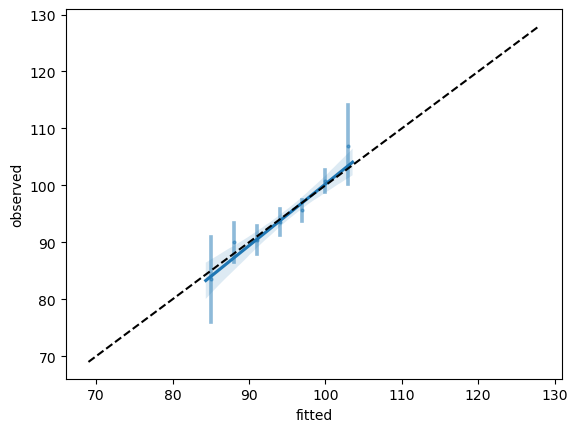

In [193]:
plot_fitted_observed(model, val_dl)


In [49]:
model, opt = get_model()
print(loss_func(model(xb), yb))

In [ ]:
NDVI_series = torch.Tensor(ds_inputs_SSA[[f'NDVI interpolated at day {n*4}' for n in range(25)]].values)
temp_series = torch.Tensor(ds_inputs_SSA[[f'temperature at day {n*4}' for n in range(25)]].values)
temp_NDVI_series = torch.swapaxes(torch.stack((temp_series, NDVI_series)), 0, 1)

In [58]:
in_channels = 2
out_channels = 4
Kernel_size = 4
c = torch.nn.Conv1d(in_channels, out_channels, Kernel_size)

In [61]:
temp_NDVI_series.shape

torch.Size([240, 2, 25])

In [60]:
c(temp_NDVI_series).shape

torch.Size([240, 4, 22])

In [33]:
ds_inputs_DE.dropna(how='any')[['Day of start', 'WC SOS date']]

# Note to self: start NDVI a bit along

,Day of start,WC SOS date
19,2018-04-03,2018-04-15
20,2019-04-03,2019-04-15
21,2020-04-02,2020-04-14
22,2021-04-03,2021-04-15
23,2022-04-03,2022-04-15
...,...,...
21500,2021-04-03,2021-04-15
21501,2022-04-03,2022-04-15
21519,2017-04-03,2017-04-17
21586,2018-04-03,2018-04-18


In [75]:
from torch.utils.data import Dataset

class PandasDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        return self.dataframe.iloc[index]


#dataloader = torch.utils.data.DataLoader(dataset, batch_size=16)

In [76]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train, test = train_test_split(ds_inputs_DE, test_size=0.2, random_state = 1)
#trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
#trainset = torch.utils.data.DataLoader(train, batch_size=len(train), train=True, transform=transform)
#testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
#trainset = torch.utils.data.DataLoader(test, batch_size=len(test), train=False, transform=transform)
trainset = PandasDataset(train)
testset = PandasDataset(test)
 
batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
 
class CNN1d(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(2, 20, kernel_size=4, stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
 
        self.conv2 = nn.Conv2d(20, 20, kernel_size=3, stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
 
        self.flat = nn.Flatten()
 
        self.fc3 = nn.Linear(128, 16)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)
 
        self.fc4 = nn.Linear(64, 16)
 
    def forward(self, x):
        # input 3x32x32, output 32x32x32
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        # input 32x32x32, output 32x32x32
        x = self.act2(self.conv2(x))
        # input 32x32x32, output 32x16x16
        x = self.pool2(x)
        # input 32x16x16, output 8192
        x = self.flat(x)
        # input 8192, output 512
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        # input 512, output 10
        x = self.fc4(x)
        return x
 
model = CNN1d()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
 
n_epochs = 10
for epoch in range(n_epochs):
    for inputs, labels in trainloader:
        # forward, backward, and then weight update
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
    acc = 0
    count = 0
    for inputs, labels in testloader:
        y_pred = model(inputs)
        acc += (torch.argmax(y_pred, 1) == labels).float().sum()
        count += len(labels)
    acc /= count
    print("Epoch %d: model accuracy %.2f%%" % (epoch, acc*100))
 
torch.save(model.state_dict(), "cifar10model.pth")

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'pandas.core.series.Series'>